## Gait Video Project
### Ablation Study on Subject generalization framework with Traditional ML models only 
* We will explore the performance of using feet coordinates only (merged from both front and side camera views), feet + ankle coordinates (merged from both front and side camera views), feet + ankle (merged from both front and side camera views) + knee (from the single front camera view) coordinates and all (feet + ankle (merged from both front and side camera views) + knee + hip (from the single front camera view)) coordinates on the traditional ML models.
* In our main traditional models, total 91 features (including the frame count and 90 CoV, range and asymmetry of the body coordinate features) were used.

In [1]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import subject_gen_traditionalML
reload(subject_gen_traditionalML)
from ml_utils.subject_gen_traditionalML import keep_common_PIDs, models, evaluate, run_ml_models
from ml_utils.subject_gen_traditionalML import design
from ast import literal_eval

In [2]:
path = 'C:\\Users\\rk4\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\rk4\\Box\Gait Video Project\\AblationResults\\ML\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

key cohort trial scenario         video  PID  stride_number  \
0  GVS_212_T_T1_1    HOA    BW     SLWT  GVS_212_T_T1  212              1   
1  GVS_212_T_T1_2    HOA    BW     SLWT  GVS_212_T_T1  212              2   
2  GVS_212_T_T1_3    HOA    BW     SLWT  GVS_212_T_T1  212              3   
3  GVS_212_T_T1_4    HOA    BW     SLWT  GVS_212_T_T1  212              4   
4  GVS_212_T_T1_5    HOA    BW     SLWT  GVS_212_T_T1  212              5   

   frame_count  label  right hip-x-CoV  ...  ankle-z-asymmetry  \
0           46      0         0.046077  ...          14.426173   
1           39      0         0.021528  ...           1.360847   
2           56      0         0.034394  ...           1.341021   
3           53      0         0.028511  ...           2.375934   
4           44      0         0.025213  ...           8.525816   

   heel-x-asymmetry  heel-y-asymmetry  heel-z-asymmetry  toe 1-x-asymmetry  \
0          3.407379         10.662441          0.830365           0.502570   
1          5.155307         11.363806          4.333776           1.025647   
2          8.625363          7.159495          3.366152           1.759968   
3          6.728268          0.098235          0.999027           0.541911   
4          1.775282          0.033210          9.166863           1.354601   

   toe 1-y-asymmetry  toe 1-z-asymmetry  toe 2-x-asymmetry  toe 2-y-asymmetry  \
0          31.450487           8.644012           5.236678          31.182183   
1          28.266400           2.671081           6.678294          15.058825   
2          17.545787           5.921325           8.243491           9.578638   
3           7.843339           4.279617           0.748023          19.471731   
4           6.674183           8.479480           4.373622           0.315168   

   toe 2-z-asymmetry  
0           8.215725  
1           4.903579  
2           3.008162  
3           5.086056  
4          11.795593  

[5 rows x 99 columns]

### Subject generalization framework 1: walking (W) to classify HOA/MS/PD strides and subjects using cross validation 

In [3]:
#Trial W for the first framework of subject generalization
trialW = data[data['scenario']=='W']
print ('Original number of subjects in trial W for cross validation:', len(trialW['PID'].unique()))
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialW = shuffle(trialW, random_state = 0)
#CV for people generalize so no train-test split
X = trialW.drop(cols_to_drop, axis = 1)
Y = trialW[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial W for cross validation: ', len(trialW))
print ('HOA, MS and PD strides in trial W:\n', trialW['cohort'].value_counts())
print ('Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y\n', trialW['cohort'].value_counts()/trialW['cohort'].value_counts()['HOA'])

#Defining the framework of interest
framework = 'W'

Original number of subjects in trial W for cross validation: 32
Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in trial W for cross validation:  1380
HOA, MS and PD strides in trial W:
 HOA    658
MS     389
PD     333
Name: cohort, dtype: int64
Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.591185
PD     0.506079
Name: cohort, dtype: float64


In [4]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5116532860962513, 0.47233025108530863, 0.5116532860962513, 0.5193551060883939, [0.610643096785483, 0.45982417722970526, 0.3465234792407375], 0.4484825068160162, 0.5116532860962513, 0.5116532860962513, [0.700551995048556, 0.4504854460577352, 0.19441007934175727], 0.4465870770476797, 0.5116532860962513, 0.5025271980604432, [0.6476170770249009, 0.4471733552200666, 0.2449707988980716], 0.6349294061090333, 0.6427144381641977]

Stride-based model performance (standard deviation):  [0.06809330723676121, 0.037290535875964155, 0.06809330723676121, 0.05583607891794428, [0.10811757482160876, 0.17103494994957302, 0.20517156076390838], 0.04727390556083375, 0.06809330723676121, 0.06809330723676121, [0.15604660936278866, 0.06925818240194662, 0.08151880453489954], 0.03912548808177191, 0.06809330723676121, 0.06440500140777133, [0.109380324694748, 0.11192998447297933, 0.122269027179

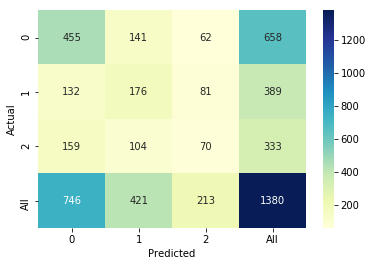

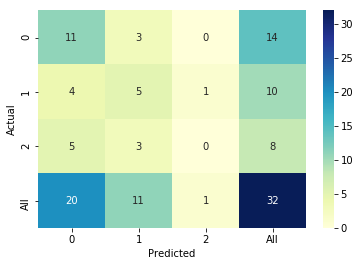

<Figure size 432x288 with 0 Axes>

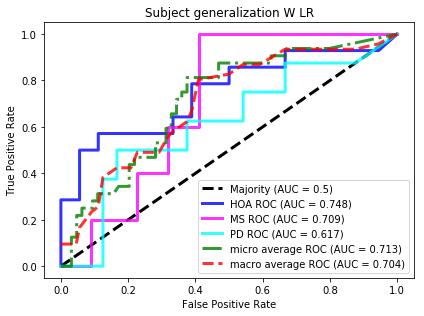

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 40}

Stride-based model performance (mean):  [0.5304945123912518, 0.5244022572925434, 0.5304945123912518, 0.5697306069327215, [0.6262234467928219, 0.4966661677130045, 0.4503171573718039], 0.4648250315507648, 0.5304945123912518, 0.5304945123912518, [0.7236069152683448, 0.46531679424249706, 0.20555138514145274], 0.45543593918228603, 0.5304945123912518, 0.5161095929108347, [0.6702681584907505, 0.44687694024978414, 0.2491627188063233], 0.6718666786908767, 0.6857533756825785]

Stride-based model performance (standard deviation):  [0.030400581586087584, 0.10069836273192798, 0.030400581586087584, 0.08091526710147719, [0.05777315210761568, 0.2702132350760699, 0.3913895237947193], 0.04120276423075946, 0.0304005815

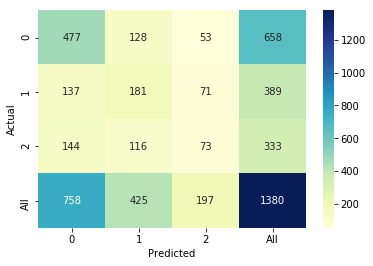

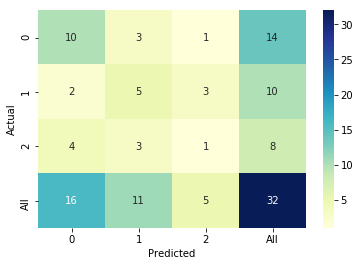

<Figure size 432x288 with 0 Axes>

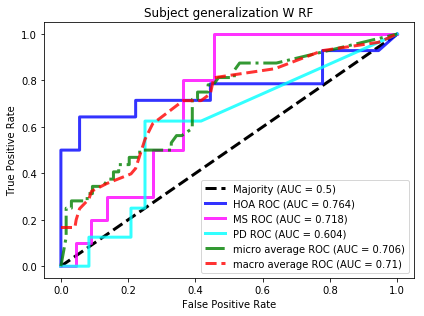

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 125}

Stride-based model performance (mean):  [0.5499242395013446, 0.3886253849502383, 0.5499242395013446, 0.4580139983603929, [0.66265681303121, 0.43333982374721586, 0.06987951807228916], 0.4808089636441945, 0.5499242395013446, 0.5499242395013446, [0.8049595884150801, 0.5056491206993216, 0.1318181818181818], 0.4232809958728462, 0.5499242395013446, 0.49278347399681577, [0.7181307678963605, 0.46037363704501244, 0.09133858267716535], 0.6510589838711172, 0.6599667945762505]

Stride-based model performance (standard deviation):  [0.1143818764133409, 0.13877745155786106, 0.1143818764133409, 0.1692801277374665, [0.18364129142264204, 0.15649686959694073, 0.15625535264456364], 0.1090414364229287, 0.1143818764133409, 0.1143818764133409, [0.11410520566047146, 0.14456602773915656, 0.29475441521588136], 0.11900675553843901, 0.1143818764133409, 0.13864188563511057,

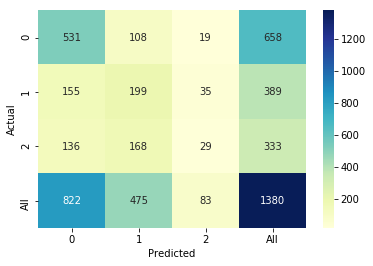

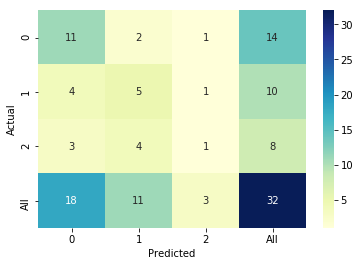

<Figure size 432x288 with 0 Axes>

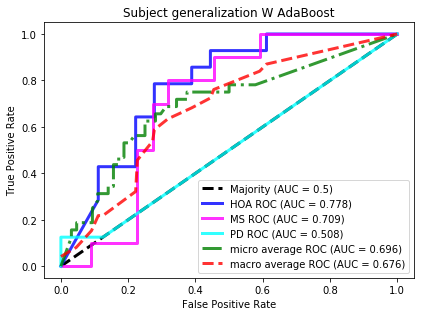

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.5214186244979458, 0.5254877060197778, 0.5214186244979458, 0.5672492634831058, [0.5934361510514534, 0.47824505358080505, 0.5047819134270747], 0.4578535927963232, 0.5214186244979458, 0.5214186244979458, [0.7094676932671354, 0.41350790626895045, 0.2505851788528838], 0.4566476017331419, 0.5214186244979458, 0.5123689818608698, [0.6423102457974545, 0.41415916670825015, 0.31347339269372093], 0.6474327825453688, 0.6572393627820788]

Stride-based model performance (standard deviation):  [0.023024597185070085, 0.05985080382870872, 0.023024597185070085, 0.04347677701659926, [0.05778103448030121, 0.25160405445557704, 0.38215863484317925], 0.0278345996878478, 0.023024597185070085, 0.023024597185070085, [0.08163774770586273, 0.14586724507041274, 0.15283506372353386], 0.035203220926352495, 0.023024597185070085, 0.03181800438931661, [0.04097720413337477, 0.1182163815592787, 0.21127

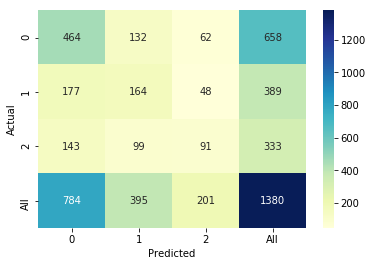

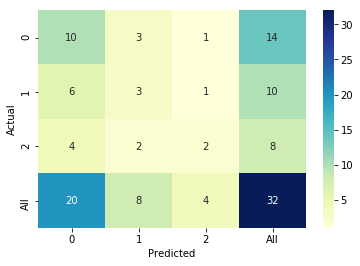

<Figure size 432x288 with 0 Axes>

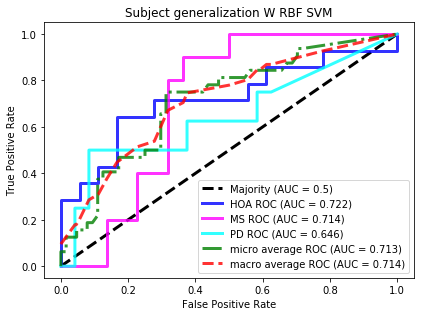

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.15, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.5349327409609588, 0.5396259099072156, 0.5349327409609588, 0.5789530062222634, [0.6435478329313812, 0.47792184413831035, 0.4974080526519551], 0.48982519699527377, 0.5349327409609588, 0.5349327409609588, [0.6863977780632636, 0.42558796439318525, 0.3574898485293725], 0.4927809319180764, 0.5349327409609588, 0.5374226952549668, [0.6577823212611845, 0.4214918983822486, 0.3990685761107962], 0.6720591281254523, 0.6834968756277238]

Stride-based model performance (standard deviation):  [0.054380017112203395, 0.05771481160028729, 0.054380017112203395, 0.07329246100515995, [0.06959242467787882, 0.2936403415617

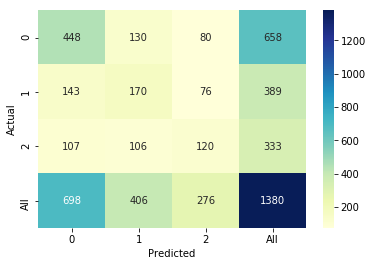

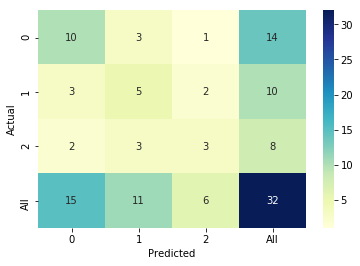

<Figure size 432x288 with 0 Axes>

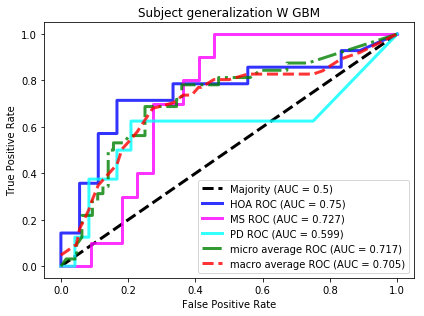

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 0.6}

Stride-based model performance (mean):  [0.5263443526384715, 0.5293034780505436, 0.5263443526384715, 0.5723021128035973, [0.6478162378637052, 0.42413529128510086, 0.5159589050028245], 0.4817724947906183, 0.5263443526384715, 0.5263443526384715, [0.6786665873808169, 0.38762837675488276, 0.37902252023615524], 0.4835816504686939, 0.5263443526384715, 0.5303884802166234, [0.656993638712084, 0.3800227255745389, 0.4137285871194586], 0.6728310680700322, 0.6851875459937082]

Stride-based model performance (standard deviation):  [0.044647447679131556, 0.05451336292592231, 0.044647447679131556, 0.06406978961673919, [0.07725526397150616, 0.2532082031398804, 0.268404594265467], 0.03996011345855534, 0.044647447679131556, 0.044647447679131556, [0.12013211119090272, 0.1696309599

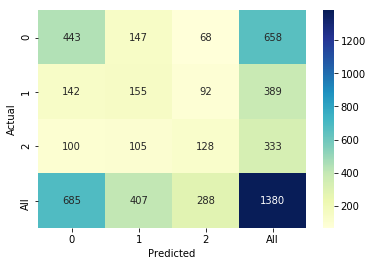

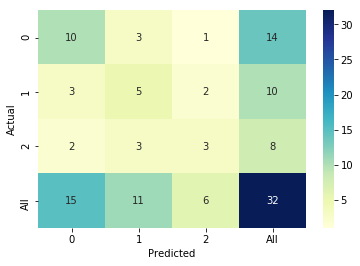

<Figure size 432x288 with 0 Axes>

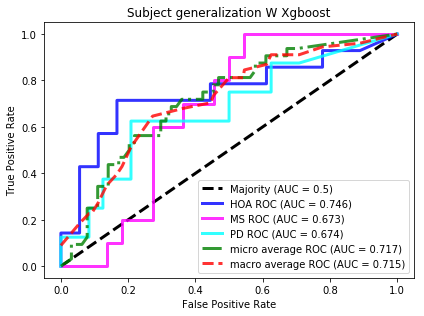

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 49}

Stride-based model performance (mean):  [0.5617362945428699, 0.5469407800952457, 0.5617362945428699, 0.5906723635555122, [0.6912668996620039, 0.46501444622792937, 0.48454099439580384], 0.5338827723233083, 0.5617362945428699, 0.5617362945428699, [0.6212341349260536, 0.5635479810981818, 0.4168662009456896], 0.5296024506997685, 0.5617362945428699, 0.5674934952748547, [0.6523861394917645, 0.5020940644606064, 0.4343271481469347], 0.6629731787834838, 0.6725348869915889]

Stride-based model performance (standard deviation):  [0.08556049205416803, 0.08654648676469877, 0.08556049205416803, 0.10787099318027199, [0.15974537848804574, 0.1528067908736663, 0.17844837997814555], 0.07734815383989635, 0.08556049205416803, 0.08556049205416803, [0.13119015382746957, 0.11895486327668951, 0.12236732243129597], 0.07425459337122979, 0.08556049205416803, 0.09153845444633929, [0.13687703361851694, 0.

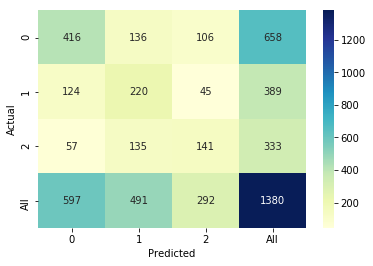

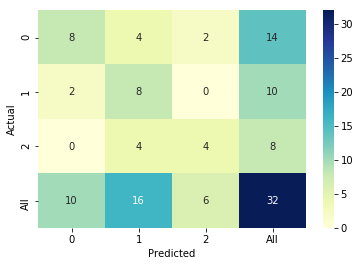

<Figure size 432x288 with 0 Axes>

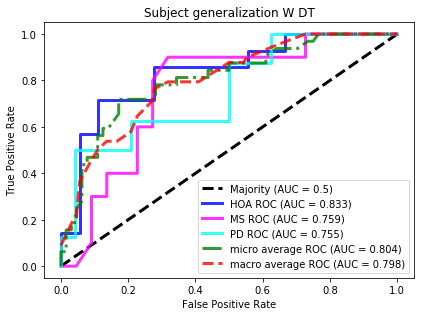

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4754814732002338, 0.44269881335791694, 0.4754814732002338, 0.4888236739953193, [0.5746362515125555, 0.40350571847884786, 0.3499544700823473], 0.41315693425629185, 0.4754814732002338, 0.4754814732002338, [0.6700868456924411, 0.39147495966773077, 0.17790899740870356], 0.40989110701643855, 0.4754814732002338, 0.4653635531756436, [0.6119919843045497, 0.3894697369958122, 0.22821159974895375], 0.6336515521522377, 0.6421849290214512]

Stride-based model performance (standard deviation):  [0.050449154473110755, 0.031142049586745293, 0.050449154473110755, 0.054755622370779584, [0.10386074577685236, 0.18538002841446977, 0.23409957831052883], 0.02609970923643681, 0.050449154473110755, 0.050449154473110755, [0.1621565955037139, 0.13572441679384434, 0.06900147115946527], 0.030113110221457445, 0.050449154473110755, 0.05884642551299234, [0.10269999710070374, 0.15242772887488656

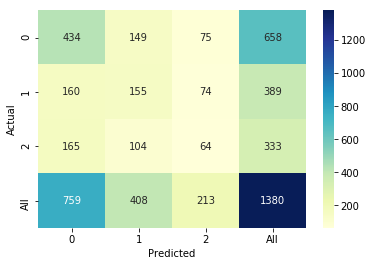

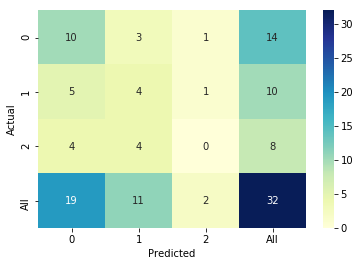

<Figure size 432x288 with 0 Axes>

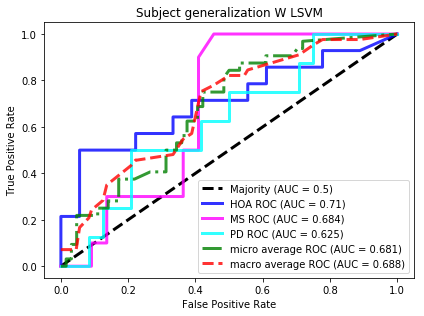

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 50, 150, 30, 150, 5)}

Stride-based model performance (mean):  [0.5531199464052747, 0.5444187505836506, 0.5531199464052747, 0.5893651779004454, [0.6697912289993606, 0.4721221464892351, 0.4913428762623564], 0.5207104755364698, 0.5531199464052747, 0.5531199464052747, [0.6505828049745893, 0.47887424341239604, 0.43267437822242405], 0.5187928194241018, 0.5531199464052747, 0.5594254058719029, [0.6570307694123102, 0.45870596968862865, 0.4406417191713668], 0.6979889197180473, 0.707306557661793]

Stride-based model performance (standard deviation):  [0.05372643454283857, 0.06940322477984852, 0.05372643454283857, 0.05240268314111332, [0.06316938675509609, 0.2028000011728401, 0.28059923788163], 0.06586350845175433, 0.05372643454283857, 0.05372643454283857, [0.14715766196498659, 0.048543979973443195, 0.21161668930290967], 0.06332016369815235, 0.05372643454283857, 0.047276360267880305, [0.10049

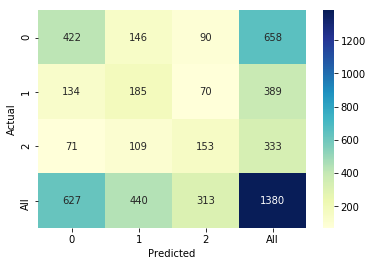

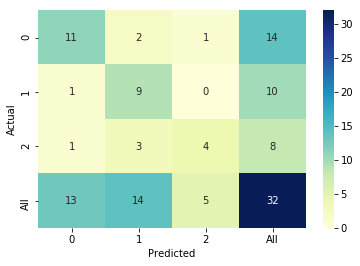

<Figure size 432x288 with 0 Axes>

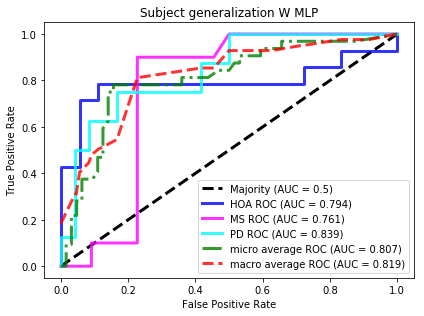

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5392946990162288, 0.504767121847074, 0.5392946990162288, 0.5434085669033534, [0.6152964704214704, 0.46508523785819306, 0.4339196572615583], 0.4841944910089193, 0.5392946990162288, 0.5392946990162288, [0.6939293705111117, 0.4739419501367293, 0.284712152378917], 0.48379785094485506, 0.5392946990162288, 0.5313298383748535, [0.6476451480118265, 0.46349563818510003, 0.3402527666376387], 0.6656629233292028, 0.6689032224674742]

Stride-based model performance (standard deviation):  [0.07500349382834563, 0.03604625493180981, 0.07500349382834563, 0.06451144004826041, [0.10648006100847215, 0.18207530566356855, 0.15868587079721277], 0.04092724869596338, 0.07500349382834563, 0.07500349382834563, [0.1466075761247119, 0.13671647548083338, 0.08200189987945007], 0.04200445595808435, 0.07500349382834563, 0.0743

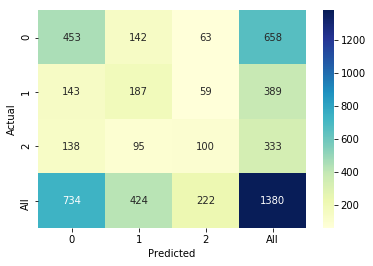

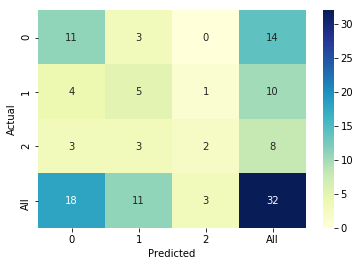

<Figure size 432x288 with 0 Axes>

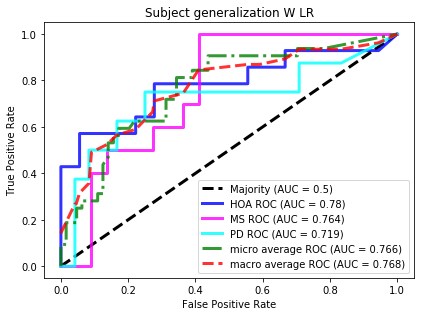

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 45}

Stride-based model performance (mean):  [0.5321007498540494, 0.5153756551338138, 0.5321007498540494, 0.5604713599508335, [0.6457198357198357, 0.4672238959732147, 0.43318323370839107], 0.49107217271495796, 0.5321007498540494, 0.5321007498540494, [0.6704467267792357, 0.4256252931955743, 0.37714449817006385], 0.48569503927576313, 0.5321007498540494, 0.5319491202644923, [0.6540605446307508, 0.42611642026099783, 0.37690815293554064], 0.6889925346053053, 0.6992796971319286]

Stride-based model performance (standard deviation):  [0.08031208922099349, 0.10672329235401115, 0.08031208922099349, 0.12246326804270598, [0.12836449129319905, 0.28621988191687325, 0.18857515112256343], 0.08832298539880383, 0.080312089220

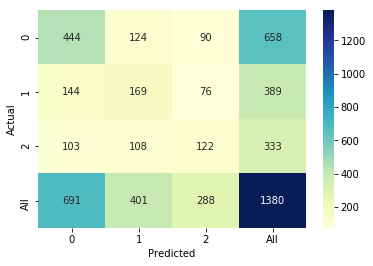

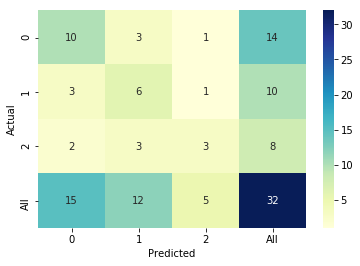

<Figure size 432x288 with 0 Axes>

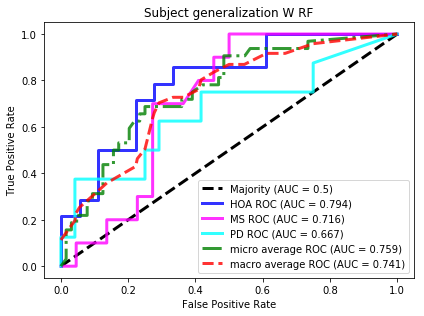

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 100}

Stride-based model performance (mean):  [0.5559861187677957, 0.39638009612441977, 0.5559861187677957, 0.4642994019076858, [0.6588092838114438, 0.46045148648952633, 0.06987951807228916], 0.48588462811083827, 0.5559861187677957, 0.5559861187677957, [0.810548027598144, 0.515287674916189, 0.1318181818181818], 0.42884100863643476, 0.5559861187677957, 0.49846736774337586, [0.7203259190741584, 0.47485852415798047, 0.09133858267716535], 0.6559229957745962, 0.6636715536118969]

Stride-based model performance (standard deviation):  [0.12156255093971394, 0.1489970591187301, 0.12156255093971394, 0.17675992370819515, [0.17419558294924609, 0.1961434382723569, 0.15625535264456364], 0.11303730568766628, 0.12156255093971394, 0.12156255093971394, [0.11682032108295914, 0.14718423308914097, 0.29475441521588136], 0.12477119357084336, 0.12156255093971394, 0.1454978447

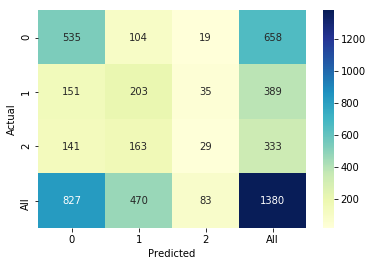

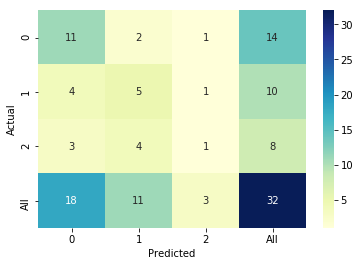

<Figure size 432x288 with 0 Axes>

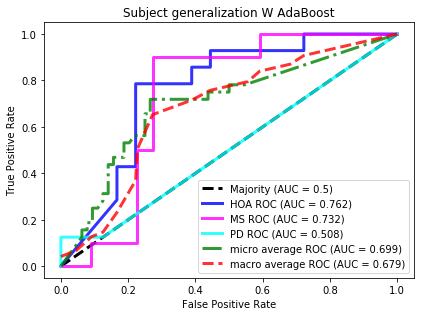

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.5141834987541729, 0.5164906283987849, 0.5141834987541729, 0.5561792223532429, [0.5716867117332943, 0.46662648228366166, 0.5111586911793987], 0.44169997214491125, 0.5141834987541729, 0.5141834987541729, [0.7343552938613328, 0.3689204968020229, 0.2218241257713782], 0.4403028744271909, 0.5141834987541729, 0.49839221886084095, [0.6395146373224883, 0.389332287456708, 0.29206169850237645], 0.6548534329456606, 0.6644301305343616]

Stride-based model performance (standard deviation):  [0.03886508481584889, 0.08041177391122277, 0.03886508481584889, 0.06353552710885023, [0.06181543722497838, 0.2845234123775353, 0.3981840075804344], 0.03993583821022819, 0.03886508481584889, 0.03886508481584889, [0.07542114321877012, 0.10490097093238877, 0.13495482946444343], 0.05319634903291001, 0.03886508481584889, 0.04969469144925135, [0.0467554923196744, 0.12888809624959452, 0.1946286822102

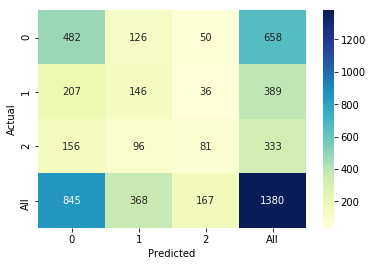

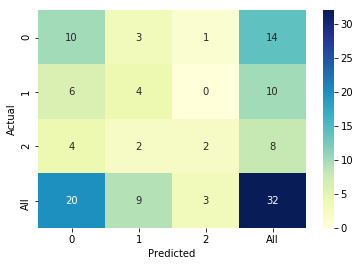

<Figure size 432x288 with 0 Axes>

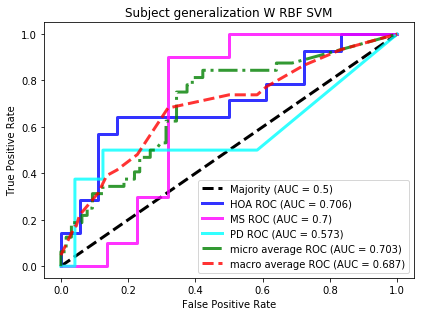

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 150}

Stride-based model performance (mean):  [0.529689594325218, 0.5294375908401155, 0.529689594325218, 0.5711842881320556, [0.6368127483725474, 0.44614038029025627, 0.5053596438575431], 0.4808789453549835, 0.529689594325218, 0.529689594325218, [0.695631163137297, 0.40198203068684996, 0.34502364224080356], 0.4834331735596356, 0.529689594325218, 0.5313204594167031, [0.6596258479121214, 0.4046556638310537, 0.38601800893573146], 0.6683112884464443, 0.6800966678978357]

Stride-based model performance (standard deviation):  [0.04519242742983019, 0.035421421788338535, 0.04519242742983019, 0.05763659901617142, [0.08232632583909631, 0.24696533956614145, 

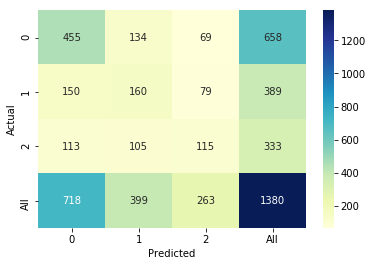

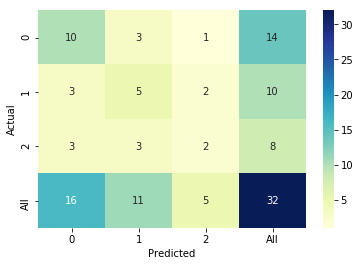

<Figure size 432x288 with 0 Axes>

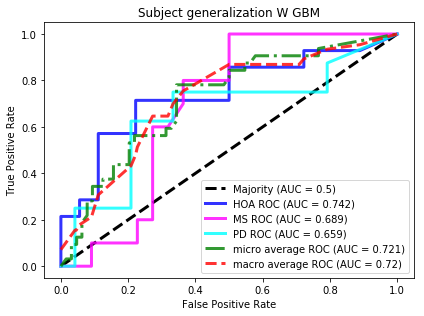

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 0.6}

Stride-based model performance (mean):  [0.5238429608548382, 0.5169528631203905, 0.5238429608548382, 0.561086528326421, [0.6315290101777316, 0.4276075823521079, 0.49172199683133205], 0.4705999412510339, 0.5238429608548382, 0.5238429608548382, [0.6903009280623167, 0.3871859231798991, 0.3343129725108861], 0.47243707432671017, 0.5238429608548382, 0.5236204508550287, [0.6534314925175542, 0.38358469670530304, 0.38029503375727336], 0.6728588772299966, 0.6854351992795534]

Stride-based model performance (standard deviation):  [0.059874073996535236, 0.05433364842416456, 0.059874073996535236, 0.07078817188997652, [0.08030833674776143, 0.29730973589622345, 0.2547971288612982], 0.04261706695501863, 0.059874073996535236, 0.059874073996535236, [0.14394886478425822, 0.192345469

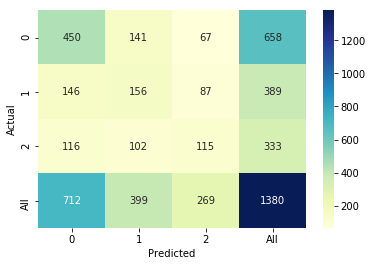

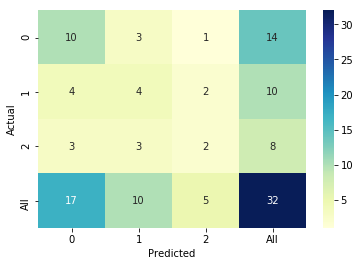

<Figure size 432x288 with 0 Axes>

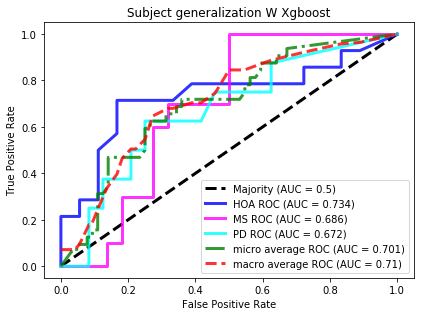

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 43}

Stride-based model performance (mean):  [0.5308044865591335, 0.5020094261038025, 0.5308044865591335, 0.5547174838887774, [0.6690790663976718, 0.4402477427960157, 0.39670146911772003], 0.5007365592026952, 0.5308044865591335, 0.5308044865591335, [0.6105530068317656, 0.5204722880124487, 0.37118438276387145], 0.4892721609319427, 0.5308044865591335, 0.5331537842763143, [0.6361570446654817, 0.46956101024244457, 0.3620984278879016], 0.6588744406916313, 0.6664810278219898]

Stride-based model performance (standard deviation):  [0.08340325838373583, 0.10616322782134671, 0.08340325838373583, 0.10830969659532365, [0.16633266916651343, 0.11755583157693998, 0.2509493896253871], 0.09813700017349407, 0.08340325838373583, 0.08340325838373583, [0.09054687457092121, 0.11407231032651302, 0.24865347029065432], 0.09591849353937755, 0.08340325838373583, 0.09127196770283343, [0.12345181612842324, 0

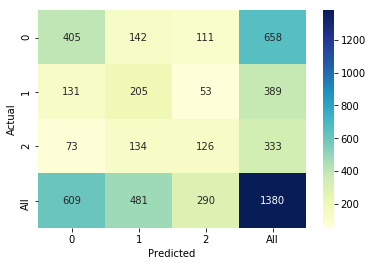

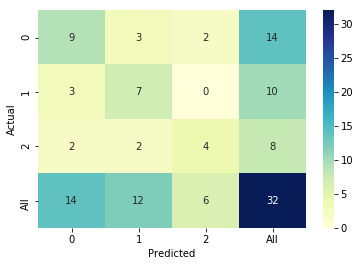

<Figure size 432x288 with 0 Axes>

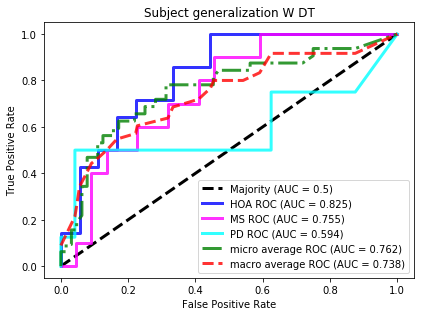

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.5051091735630485, 0.4793452429808786, 0.5051091735630485, 0.519635263394316, [0.5931718536522891, 0.3972551055728626, 0.4476087697174841], 0.4549758277339796, 0.5051091735630485, 0.5051091735630485, [0.65933314490092, 0.4121532569022529, 0.2934410813987658], 0.45417865303940685, 0.5051091735630485, 0.5004168036169346, [0.6188514754243596, 0.3994821007524542, 0.3442023829414068], 0.6473067006298472, 0.6525533449674302]

Stride-based model performance (standard deviation):  [0.06067758012628428, 0.038181231447166196, 0.06067758012628428, 0.06201009296904666, [0.11630565800150262, 0.18428941366171162, 0.20640606310403478], 0.04281476978158414, 0.06067758012628428, 0.06067758012628428, [0.13663362413028338, 0.17721742651783295, 0.054834185663496], 0.043799148772509074, 0.06067758012628428, 0.06664746609608295, [0.10356758917345502, 0.1791094010363436, 0.1056432811703

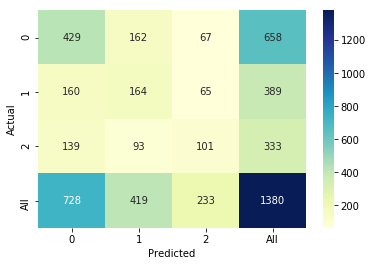

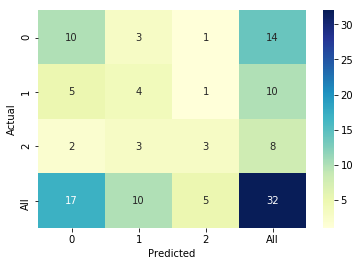

<Figure size 432x288 with 0 Axes>

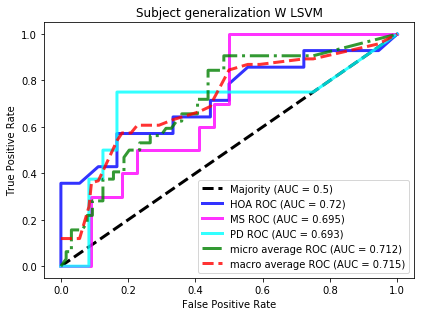

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (21, 21, 7, 84, 21, 84, 84)}

Stride-based model performance (mean):  [0.5516203394092983, 0.5546645548209336, 0.5516203394092983, 0.591406119682428, [0.6524450801723529, 0.5449809132366678, 0.46656767105377994], 0.5232323039360203, 0.5516203394092983, 0.5516203394092983, [0.6627223777694169, 0.5014359718074577, 0.4055385622311864], 0.5229202224715231, 0.5516203394092983, 0.5576276170458008, [0.6566560614447586, 0.4993538295158051, 0.4127507764540058], 0.69692015658478, 0.7038178772087116]

Stride-based model performance (standard deviation):  [0.050180056371522105, 0.07746767371897896, 0.050180056371522105, 0.07470969672320983, [0.032900551234616306, 0.24079390429045872, 0.2552935880446519], 0.06356538175684129, 0.050180056371522105, 0.050180056371522105, [0.053570433157401356, 0.14670160668164975, 0.0484378784383328], 0.0575811467096783, 0.050180056371522105, 0.04655266231628049, [0.0339018441332

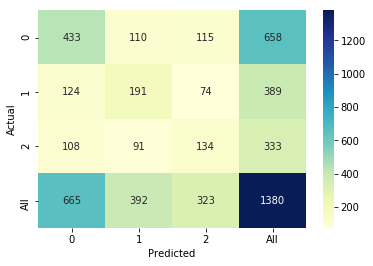

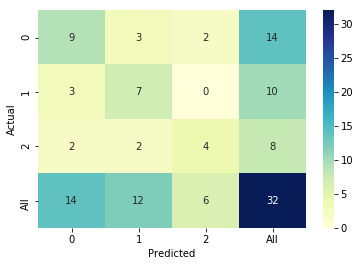

<Figure size 432x288 with 0 Axes>

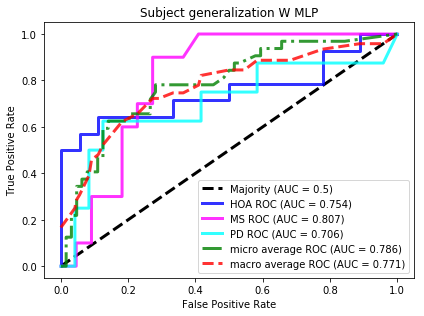

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.5509259712568536, 0.5420565315687512, 0.5509259712568536, 0.57241308754102, [0.6310631815864066, 0.5334820412867466, 0.4616243718331005], 0.5312427707881786, 0.5509259712568536, 0.5509259712568536, [0.6486474201955351, 0.5198870124372132, 0.42519387973178746], 0.5206034664291829, 0.5509259712568536, 0.5477766021470727, [0.6331259958436816, 0.5182499491494338, 0.4104344542944331], 0.714882524075783, 0.712258815582344]

Stride-based model performance (standard deviation):  [0.08203161248755424, 0.07575961620747063, 0.08203161248755424, 0.09697501143609781, [0.12581599221769343, 0.1646240487942851, 0.1052394925153504], 0.07299188184003173, 0.08203161248755424, 0.08203161248755424, [0.1503411002386081, 0.07866306139740065, 0.17476741858832223], 0.07093425140268186, 0.08203161248755424, 0.08722

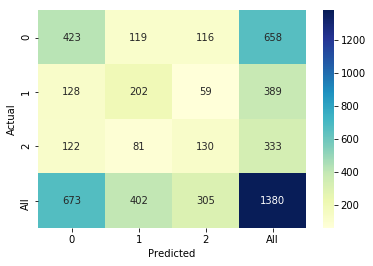

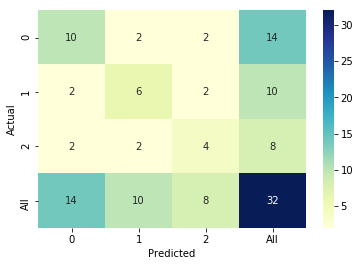

<Figure size 432x288 with 0 Axes>

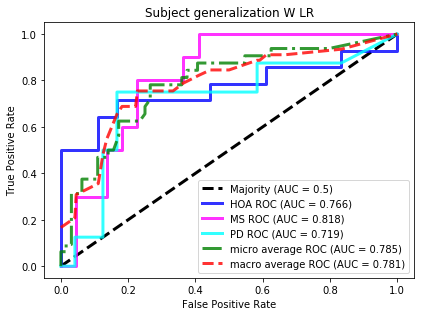

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 45}

Stride-based model performance (mean):  [0.531931794844551, 0.5162317512293727, 0.531931794844551, 0.5621208204649027, [0.6570653161594152, 0.4839894082028914, 0.4076405293258117], 0.48598514409779237, 0.531931794844551, 0.531931794844551, [0.6887394403986212, 0.4330537820798865, 0.3361622098148692], 0.48295298119498237, 0.531931794844551, 0.5316837052290155, [0.6708954135651881, 0.42944254139636745, 0.3485209886233915], 0.6862910048519842, 0.698133762085943]

Stride-based model performance (standard deviation):  [0.047705747844750894, 0.039661430256776285, 0.047705747844750894, 0.06512816057946051, [0.07986372698365883, 0.21072187439706846, 0.16470950003552942], 0.0196238954412446, 0.0477057478447

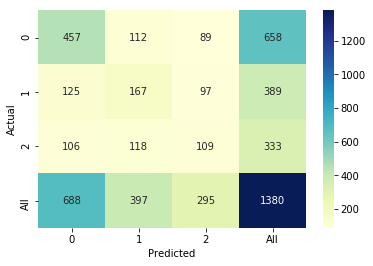

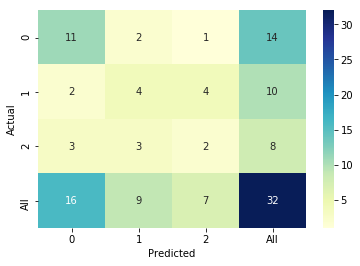

<Figure size 432x288 with 0 Axes>

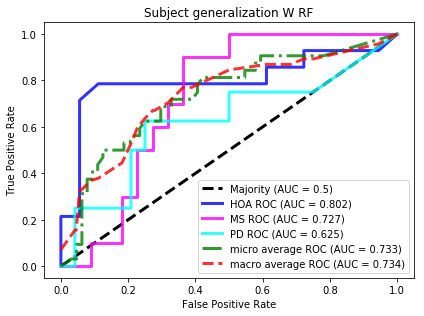

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.5554020805799501, 0.5488682185835345, 0.5554020805799501, 0.6033884305281261, [0.6993128705102212, 0.5090595982218603, 0.43823218701852207], 0.5082058996531525, 0.5554020805799501, 0.5554020805799501, [0.7460399813512278, 0.4629492614331972, 0.3156284561750327], 0.4776554561556129, 0.5554020805799501, 0.5379205436047075, [0.7129834435060516, 0.4445195066586591, 0.275463418302128], 0.6678002243687965, 0.6769683613193005]

Stride-based model performance (standard deviation):  [0.09431559614864679, 0.11269339198032173, 0.09431559614864679, 0.12197407669942986, [0.16169048799355493, 0.2407729012745905, 0.27854457098341817], 0.08776770989356003, 0.09431559614864679, 0.09431559614864679, [0.16245936560873747, 0.19016821907705406, 0.35569854560943553], 0.06620715861597606, 0.09431559614864679, 0.08278610357595811

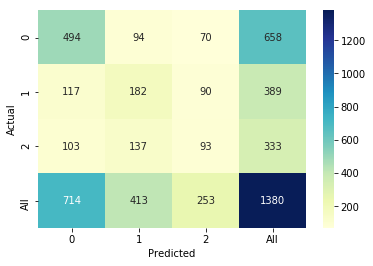

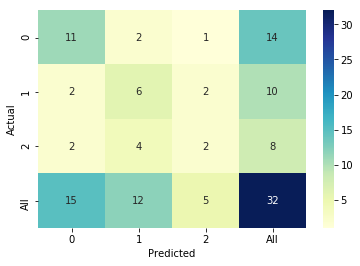

<Figure size 432x288 with 0 Axes>

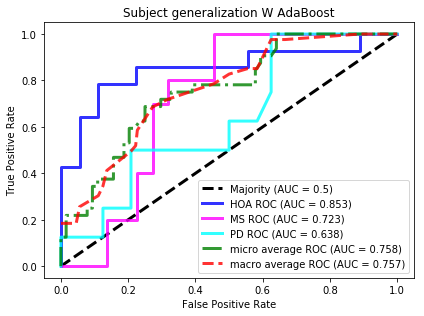

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}

Stride-based model performance (mean):  [0.5204115734591751, 0.5369166682852642, 0.5204115734591751, 0.5690835089282994, [0.5582154909932583, 0.47121176253978275, 0.5813227513227514], 0.4373604908016032, 0.5204115734591751, 0.5204115734591751, [0.8012214647593675, 0.2724327509468072, 0.23842725669863488], 0.42857784712710123, 0.5204115734591751, 0.48852386223678756, [0.6558867955209542, 0.32223989318208074, 0.30760685267826865], 0.7061135568883223, 0.7126172174513812]

Stride-based model performance (standard deviation):  [0.06371906650602265, 0.09123643693899515, 0.06371906650602265, 0.07659562706033016, [0.08747396021534702, 0.32879953757708485, 0.40289179627003285], 0.05744786921442366, 0.06371906650602265, 0.06371906650602265, [0.066191724017612, 0.07880415432124793, 0.15554435768727473], 0.06694192050283412, 0.06371906650602266, 0.06759663405226322, [0.0778810759207017, 0.11201661059430816, 0.1740122269

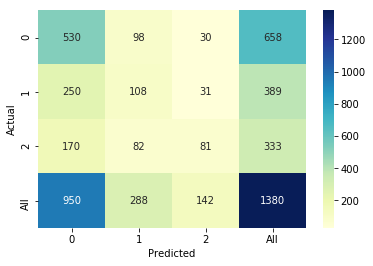

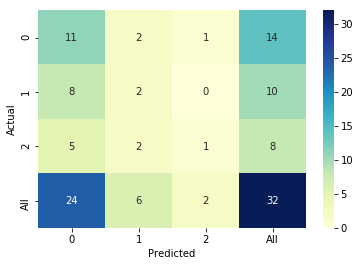

<Figure size 432x288 with 0 Axes>

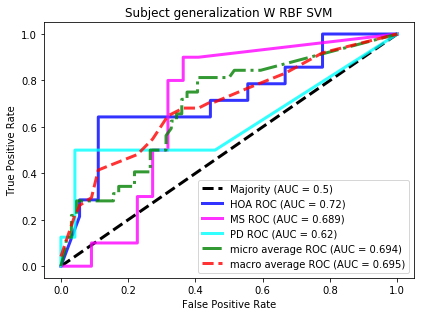

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 150}

Stride-based model performance (mean):  [0.5386989714288137, 0.5492137321478869, 0.5386989714288137, 0.5886651824178902, [0.6561433913957057, 0.4803647198096068, 0.5111330852383484], 0.5019125366585848, 0.5386989714288137, 0.5386989714288137, [0.6719570781542786, 0.4209847366674676, 0.4127957951540085], 0.5028876634475402, 0.5386989714288137, 0.5447479220753401, [0.6596625055907033, 0.420876949179649, 0.4281235355722681], 0.6745576724540596, 0.6859466973645076]

Stride-based model performance (standard deviation):  [0.05284069617122447, 0.037288090273939756, 0.05284069617122447, 0.0646227296919591, [0.08177389845856793, 0.23570419591823522, 

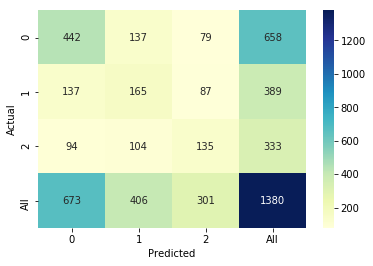

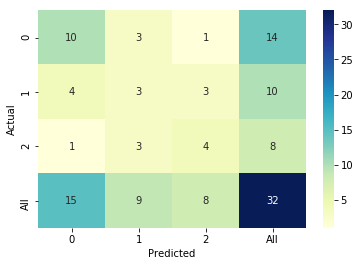

<Figure size 432x288 with 0 Axes>

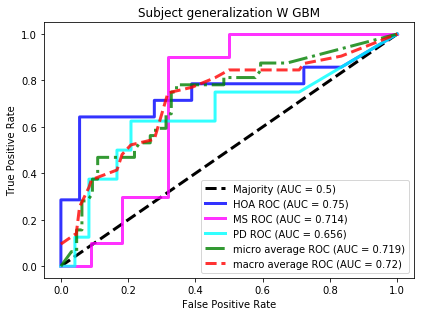

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}

Stride-based model performance (mean):  [0.5324934956376486, 0.5417252188570778, 0.5324934956376486, 0.5794438811031228, [0.6450697777555432, 0.4661300505050505, 0.5139758283106398], 0.503940169955183, 0.5324934956376486, 0.5324934956376486, [0.650067327243525, 0.39730002631609057, 0.46445315630593326], 0.49973995926626935, 0.5324934956376486, 0.5376388650768936, [0.642648348143085, 0.4063812149231884, 0.45019031473253485], 0.6888000712884046, 0.6972653536273642]

Stride-based model performance (standard deviation):  [0.06952937073802128, 0.05596331404988926, 0.06952937073802128, 0.08525349844234664, [0.11966530500797432, 0.22505813963396432, 0.16145852063491106], 0.058945207707980514, 0.06952937073802128, 0.06952937073802128, [0.11368296355202298, 0.06702104618

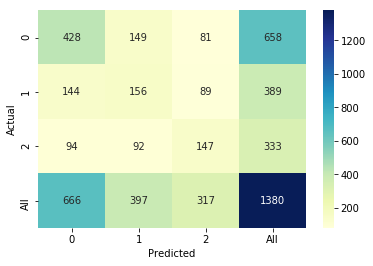

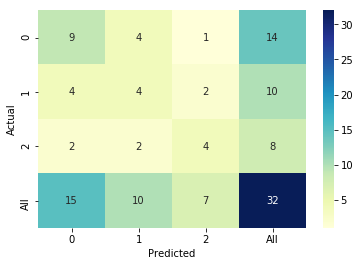

<Figure size 432x288 with 0 Axes>

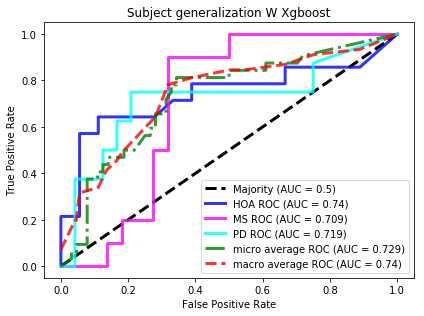

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 41}

Stride-based model performance (mean):  [0.552431565485874, 0.523475025581894, 0.552431565485874, 0.5627743879577961, [0.6456621872244801, 0.4406732874968169, 0.48408960202438467], 0.5114195769724093, 0.552431565485874, 0.552431565485874, [0.7050306489822208, 0.38473772583210336, 0.4444903561029038], 0.5048833541699165, 0.552431565485874, 0.5476031049196527, [0.6697295539485032, 0.4063994808063441, 0.4385210277549021], 0.657367547028216, 0.6657754245372374]

Stride-based model performance (standard deviation):  [0.07326112444199018, 0.06406263614442786, 0.07326112444199018, 0.08638317692093374, [0.13366756692826245, 0.18461571660067402, 0.1332704863641986], 0.07779315044193519, 0.07326112444199018, 0.07326112444199018, [0.13387948749819273, 0.10126691752818218, 0.21017746307034926], 0.06089264672761367, 0.07326112444199018, 0.07331682185168384, [0.11454386292698084, 0.1325368

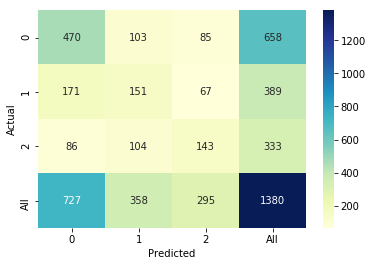

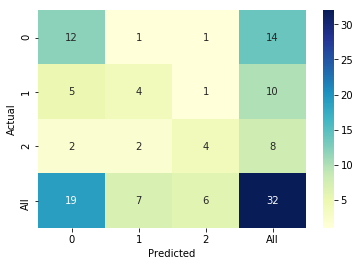

<Figure size 432x288 with 0 Axes>

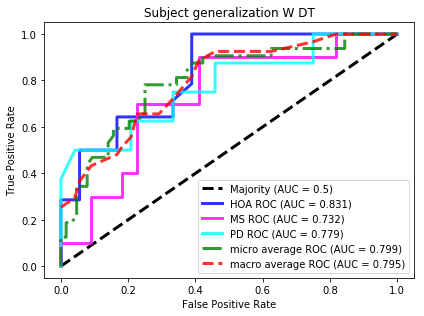

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.5363711168744454, 0.5359210508983996, 0.5363711168744454, 0.5664890162664852, [0.6203696969626713, 0.46880374066009545, 0.5185897150724319], 0.5107230956038246, 0.5363711168744454, 0.5363711168744454, [0.6569683753964375, 0.46436735546173297, 0.41083355595330323], 0.5025588985450676, 0.5363711168744454, 0.5332521800611058, [0.6281409773947034, 0.45942007297562626, 0.42011564526487355], 0.7040544779342345, 0.7035184703756737]

Stride-based model performance (standard deviation):  [0.0799982230550202, 0.06258104375574773, 0.0799982230550202, 0.08926058269680391, [0.13654437151243634, 0.18214569190827382, 0.12503786290800126], 0.07918132340923661, 0.0799982230550202, 0.0799982230550202, [0.14343123349439282, 0.12515132158075312, 0.17249640181048798], 0.0712738404916239, 0.0799982230550202, 0.08539434597459411, [0.10226785724278263, 0.14287487665653634, 0.05149850739

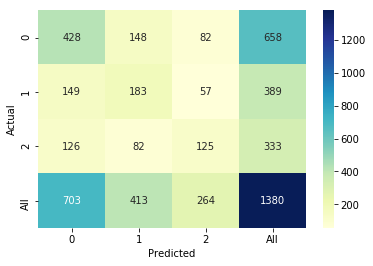

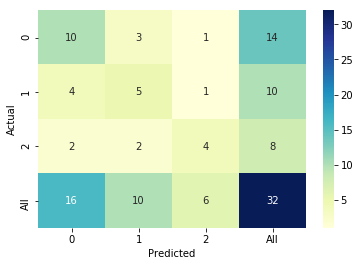

<Figure size 432x288 with 0 Axes>

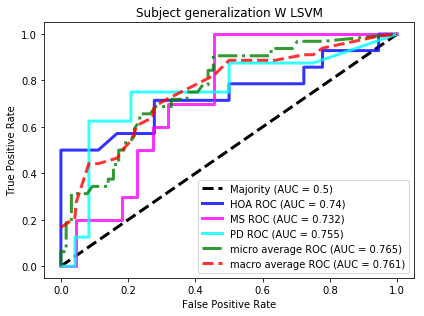

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (21, 84, 7, 7, 7, 84, 5)}

Stride-based model performance (mean):  [0.5351251320884132, 0.5085740658012338, 0.5351251320884132, 0.5509619266584523, [0.6266393263654928, 0.45138679706888873, 0.4476960739693196], 0.48714957342413256, 0.5351251320884132, 0.5351251320884132, [0.6969702362197635, 0.38798701930228036, 0.37649146475035394], 0.48457848586833674, 0.5351251320884132, 0.5306863210318307, [0.6531791737874687, 0.4063966092127293, 0.39415967460481216], 0.6869034635518034, 0.6912977315470805]

Stride-based model performance (standard deviation):  [0.039967605826573105, 0.05526381276375663, 0.039967605826573105, 0.0630189801920755, [0.0542691433164355, 0.25842035956655673, 0.19796765117259926], 0.04083207273672482, 0.039967605826573105, 0.039967605826573105, [0.1281536516034858, 0.15974517951656686, 0.08826001869970229], 0.044892578267065476, 0.039967605826573105, 0.04972524955258005, [0.062140964

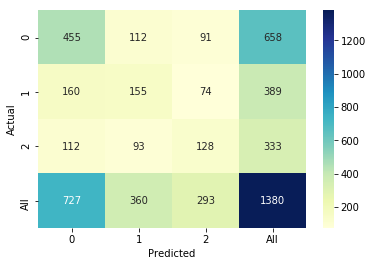

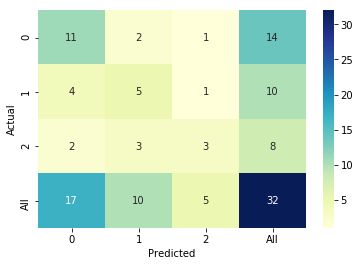

<Figure size 432x288 with 0 Axes>

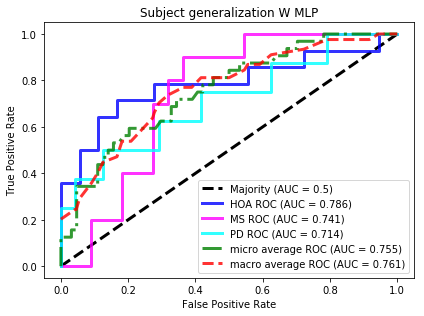

********************************
********************************


In [5]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X[datastream], Y, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics.to_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [6]:
metrics

(logistic_regression, feet)  \
stride_accuracy_mean                                                       0.511653   
stride_precision_macro_mean                                                 0.47233   
stride_precision_micro_mean                                                0.511653   
stride_precision_weighted_mean                                             0.519355   
stride_precision_class_wise_mean  [0.610643096785483, 0.45982417722970526, 0.346...   
stride_recall_macro_mean                                                   0.448483   
stride_recall_micro_mean                                                   0.511653   
stride_recall_weighted_mean                                                0.511653   
stride_recall_class_wise_mean     [0.700551995048556, 0.4504854460577352, 0.1944...   
stride_F1_macro_mean                                                       0.446587   
stride_F1_micro_mean                                                       0.511653   
stride_F1_weighted_mean                                                    0.502527   
stride_F1_class_wise_mean         [0.6476170770249009, 0.4471733552200666, 0.244...   
stride_AUC_macro_mean                                                      0.634929   
stride_AUC_weighted_mean                                                   0.642714   
stride_accuracy_std                                                       0.0680933   
stride_precision_macro_std                                                0.0372905   
stride_precision_micro_std                                                0.0680933   
stride_precision_weighted_std                                             0.0558361   
stride_precision_class_wise_std   [0.10811757482160876, 0.17103494994957302, 0.2...   
stride_recall_macro_std                                                   0.0472739   
stride_recall_micro_std                                                   0.0680933   
stride_recall_weighted_std                                                0.0680933   
stride_recall_class_wise_std      [0.15604660936278866, 0.06925818240194662, 0.0...   
stride_F1_macro_std                                                       0.0391255   
stride_F1_micro_std                                                       0.0680933   
stride_F1_weighted_std                                                     0.064405   
stride_F1_class_wise_std          [0.109380324694748, 0.11192998447297933, 0.122...   
stride_AUC_macro_std                                                      0.0191982   
stride_AUC_weighted_std                                                   0.0250337   
person_accuracy_mean                                                       0.509524   
person_precision_macro_mean                                                0.433333   
person_precision_micro_mean                                                0.509524   
person_precision_weighted_mean                                             0.738095   
person_precision_class_wise_mean                                    [0.8, 0.5, 0.0]   
person_recall_macro_mean                                                   0.321111   
person_recall_micro_mean                                                   0.509524   
person_recall_weighted_mean                                                0.509524   
person_recall_class_wise_mean         [0.5466666666666666, 0.4166666666666667, 0.0]   
person_F1_macro_mean                                                       0.361587   
person_F1_micro_mean                                                       0.509524   
person_F1_weighted_mean                                                    0.590068   
person_F1_class_wise_mean                                           [0.8, 0.5, 0.0]   
person_AUC_macro_mean                                                      0.691667   
person_AUC_weighted_mean                                                   0.711706   
person_accuracy_std                                   

### Reading the final metrics from the saved file

In [7]:
ablation_subject_generalizeW = pd.read_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_subject_generalizeW.index = ablation_subject_generalizeW['Unnamed: 0']
ablation_subject_generalizeW.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_subject_generalizeW.columns = [literal_eval(ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_subject_generalizeW.loc['person_accuracy_mean'].index))]

In [8]:
ablation_subject_generalizeW

(logistic_regression, feet)  \
Unnamed: 0                                                                            
stride_accuracy_mean                                             0.5116532860962513   
stride_precision_macro_mean                                     0.47233025108530863   
stride_precision_micro_mean                                      0.5116532860962513   
stride_precision_weighted_mean                                   0.5193551060883939   
stride_precision_class_wise_mean  [0.610643096785483, 0.45982417722970526, 0.346...   
stride_recall_macro_mean                                         0.4484825068160162   
stride_recall_micro_mean                                         0.5116532860962513   
stride_recall_weighted_mean                                      0.5116532860962513   
stride_recall_class_wise_mean     [0.700551995048556, 0.4504854460577352, 0.1944...   
stride_F1_macro_mean                                             0.4465870770476797   
stride_F1_micro_mean                                             0.5116532860962513   
stride_F1_weighted_mean                                          0.5025271980604432   
stride_F1_class_wise_mean         [0.6476170770249009, 0.4471733552200666, 0.244...   
stride_AUC_macro_mean                                            0.6349294061090333   
stride_AUC_weighted_mean                                         0.6427144381641977   
stride_accuracy_std                                             0.06809330723676121   
stride_precision_macro_std                                     0.037290535875964155   
stride_precision_micro_std                                      0.06809330723676121   
stride_precision_weighted_std                                   0.05583607891794428   
stride_precision_class_wise_std   [0.10811757482160876, 0.17103494994957302, 0.2...   
stride_recall_macro_std                                         0.04727390556083375   
stride_recall_micro_std                                         0.06809330723676121   
stride_recall_weighted_std                                      0.06809330723676121   
stride_recall_class_wise_std      [0.15604660936278866, 0.06925818240194662, 0.0...   
stride_F1_macro_std                                             0.03912548808177191   
stride_F1_micro_std                                             0.06809330723676121   
stride_F1_weighted_std                                          0.06440500140777133   
stride_F1_class_wise_std          [0.109380324694748, 0.11192998447297933, 0.122...   
stride_AUC_macro_std                                           0.019198176508117257   
stride_AUC_weighted_std                                        0.025033683336835155   
person_accuracy_mean                                             0.5095238095238095   
person_precision_macro_mean                                      0.4333333333333333   
person_precision_micro_mean                                      0.5095238095238095   
person_precision_weighted_mean                                   0.7380952380952381   
person_precision_class_wise_mean                                    [0.8, 0.5, 0.0]   
person_recall_macro_mean                                        0.32111111111111107   
person_recall_micro_mean                                         0.5095238095238095   
person_recall_weighted_mean                                      0.5095238095238095   
person_recall_class_wise_mean         [0.5466666666666666, 0.4166666666666667, 0.0]   
person_F1_macro_mean                                            0.36158730158730157   
person_F1_micro_mean                                             0.5095238095238095   
person_F1_weighted_mean                                          0.5900680272108845   
person_F1_class_wise_mean                                           [0.8, 0.5, 0.0]   
person_AUC_macro_mean                                            0.6916666666666667   
person_AUC_weighted_mean                              

### Heatmap for person mean accuracy for all algorithms and data streams for Subject generalize in trial W

In [9]:
person_accuracy_subject_generlaizeW = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_subject_generalizeW.columns)):
    x = ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_subject_generalizeW.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_subject_generlaizeW.loc[x, y] = ablation_subject_generalizeW.loc['person_accuracy_mean'][(y, x)]

person_accuracy_subject_generlaizeW = person_accuracy_subject_generlaizeW.astype(float)

In [10]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_subject_generlaizeW.loc['All features'] = [np.nan]*9

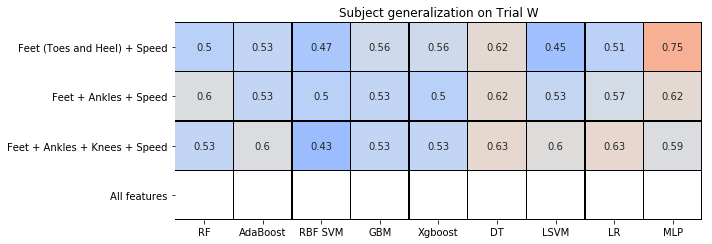

In [11]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_subject_generlaizeW, vmin=0.3, vmax=1.0, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Subject generalization on Trial W')
plt.tight_layout()
plt.savefig(results_path + framework + '\\subject_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()

### Subject generalization framework 2: walking while talking (WT) to classify strides and subjects of HOA/MS/PD

In [12]:
#Trial WT for the second framework of subject generalization
trialWT = data[data['scenario']=='WT']
print ('Original number of subjects in trial WT for cross validation:', len(trialWT['PID'].unique()))
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialWT = shuffle(trialWT, random_state = 0)
#CV for people generalize so no train-test split
X_WT = trialWT.drop(cols_to_drop, axis = 1)
Y_WT = trialWT[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial WT for cross validation: ', len(trialWT))
print ('HOA, MS and PD strides in trial WT:\n', trialWT['cohort'].value_counts())
print ('Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y\n', trialWT['cohort'].value_counts()/trialWT['cohort'].value_counts()['HOA'])
#Defining the framework of interest
framework = 'WT'

Original number of subjects in trial WT for cross validation: 26
Number of subjects in trial WT in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in trial WT for cross validation:  1050
HOA, MS and PD strides in trial WT:
 PD     367
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y
 PD     1.045584
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64


In [13]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics_WT = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.3807142762988591, 0.4366167539075473, 0.3807142762988591, 0.464860689914065, [0.3362198685941135, 0.43661303630363035, 0.537017356824898], 0.3894224492169037, 0.3807142762988591, 0.3807142762988591, [0.3334593507585421, 0.3412987686003318, 0.49350922829183697], 0.36206256997498504, 0.3807142762988591, 0.36468046117882646, [0.3285608609911772, 0.31837025881626074, 0.4392565901175173], 0.5865168406930874, 0.5915403730232298]

Stride-based model performance (standard deviation):  [0.13286292203045727, 0.10680315619204211, 0.13286292203045727, 0.10520951523659966, [0.2592077426210226, 0.279560475748365, 0.18327805846946565], 0.13110842044946602, 0.13286292203045727, 0.13286292203045727, [0.1964859082263077, 0.21286695975917772, 0.3564607963210103], 0.1422104898750283, 0.13286292203045727, 0.14127171481998962, [0.2246487649854405, 0.15510383084081417, 0.2179701497080005

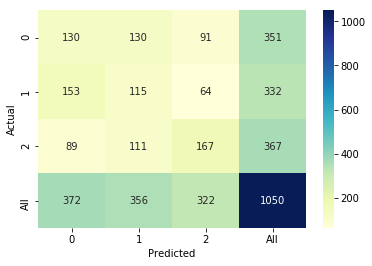

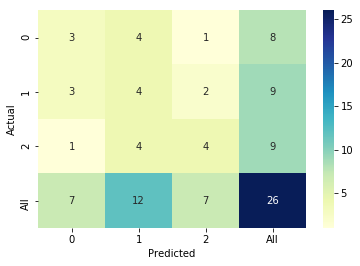

<Figure size 432x288 with 0 Axes>

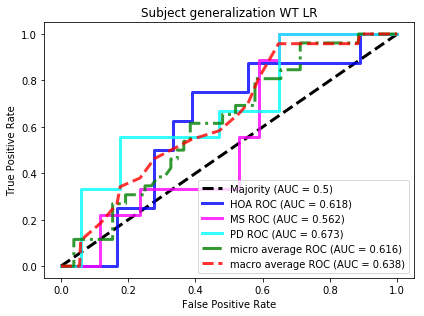

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 40}

Stride-based model performance (mean):  [0.4429469607480995, 0.4455407637787733, 0.4429469607480995, 0.46509606996800673, [0.4143271488571885, 0.24582533250354585, 0.6764698099755856], 0.44389996442472546, 0.4429469607480995, 0.4429469607480995, [0.4754520740724928, 0.20145199773919573, 0.654795821462488], 0.39368445967528914, 0.4429469607480995, 0.40266811122241347, [0.4175969975024983, 0.2175444726298723, 0.5459119088934967], 0.6874925000959321, 0.6942557166210049]

Stride-based model performance (standard deviation):  [0.1265671405506026, 0.16402782035512026, 0.1265671405506026, 0.17676099141009208, [0.3202016383367378, 0.1918053512238187, 0.21302238438588175], 0.11937282830662713, 0.1265671405506

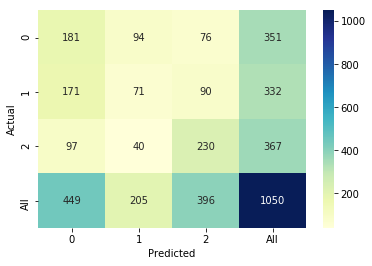

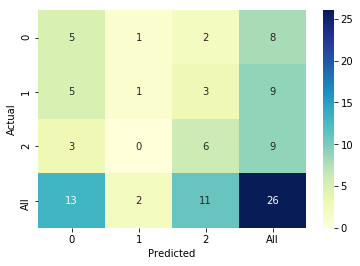

<Figure size 432x288 with 0 Axes>

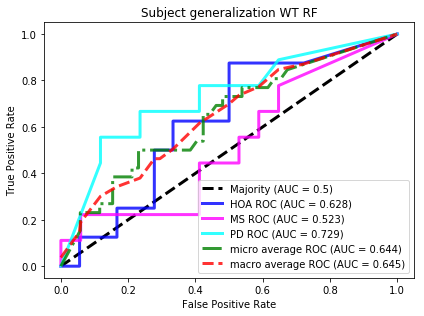

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 75}

Stride-based model performance (mean):  [0.4457556415488336, 0.42702857506967273, 0.4457556415488336, 0.4446316249957979, [0.40492451100648097, 0.29145021645021646, 0.5847109977523208], 0.44303319243632766, 0.4457556415488336, 0.4457556415488336, [0.6369268268384976, 0.0884277568704193, 0.6037449936000661], 0.36262658150722055, 0.4457556415488336, 0.3739542886808941, [0.4697530563297198, 0.11686138672265617, 0.5012653014692857], 0.681168080378796, 0.6869396963990939]

Stride-based model performance (standard deviation):  [0.1063153527733468, 0.12798441343220474, 0.1063153527733468, 0.14534976899448293, [0.27668049147498813, 0.09071853095205307, 0.18581078721694355], 0.09600147905781621, 0.1063153527733468, 0.1063153527733468, [0.3930721896343564, 0.09490872763314226, 0.3882649218401885], 0.1231771268797575, 0.1063153527733468, 0.1331140572653971, 

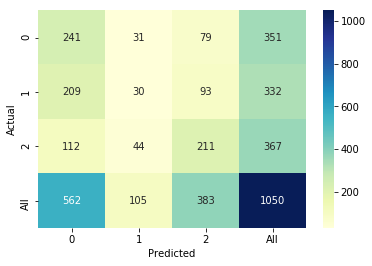

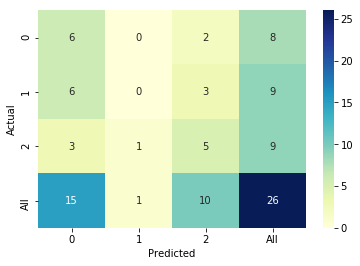

<Figure size 432x288 with 0 Axes>

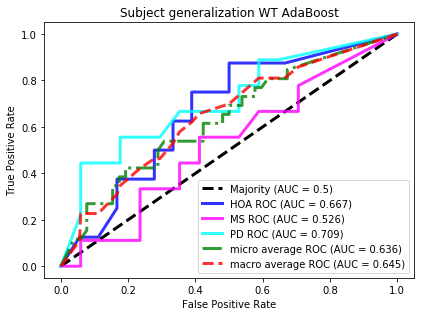

********************************
kernel_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4939371468492837, 0.41175278587271286, 0.4939371468492837, 0.4360032121669552, [0.416903881492982, 0.10420332355816227, 0.7141511525669941], 0.49292746688170785, 0.4939371468492837, 0.4939371468492837, [0.6694531430889156, 0.11854103343465044, 0.6907882241215575], 0.4050844819963828, 0.4939371468492837, 0.4177276985228072, [0.5050489948823194, 0.10505606092659192, 0.6051483901802373], 0.7090426046827972, 0.7176777500046387]

Stride-based model performance (standard deviation):  [0.12158635058147987, 0.16792850767766596, 0.12158635058147987, 0.18549885273612368, [0.2743285277102329, 0.18639023867104199, 0.25173279571451174], 0.10199833530608475, 0.12158635058147987, 0.12158635058147987, [0.37541312369584884, 0.25333940807373706, 0.33334456140806873], 0.12037741161721909, 0.12158635058147987, 0.13172343709589787, [0.30845963557564926, 0.21615238382140273, 0.1285952

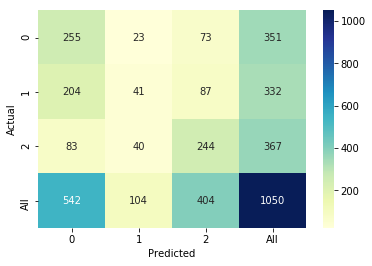

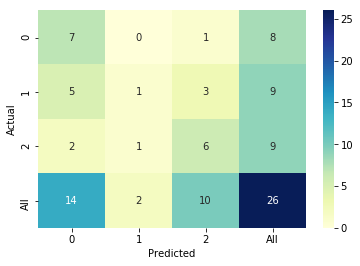

<Figure size 432x288 with 0 Axes>

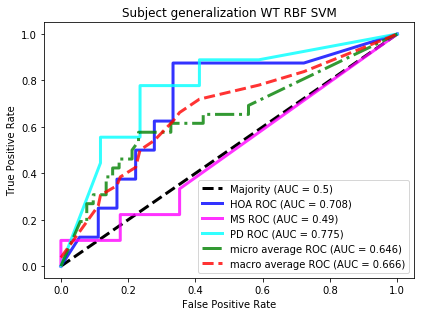

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.41915423277562197, 0.45697135715715687, 0.41915423277562197, 0.4816591104721857, [0.38974872649481734, 0.46866332615110495, 0.5125020188255482], 0.42792569129831987, 0.41915423277562197, 0.41915423277562197, [0.4153149602635703, 0.3468096919789678, 0.5216524216524216], 0.3923997836846376, 0.41915423277562197, 0.393593085472783, [0.3934908454111218, 0.34645302715478155, 0.43725547848800955], 0.5969173004716102, 0.6021304618907581]

Stride-based model performance (standard deviation):  [0.12233865410794177, 0.09091154898563897, 0.12233865410794177, 0.08414935694345277, [0.30082638823697444, 0.30907713

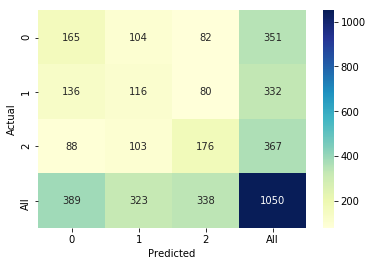

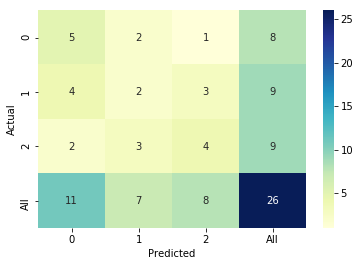

<Figure size 432x288 with 0 Axes>

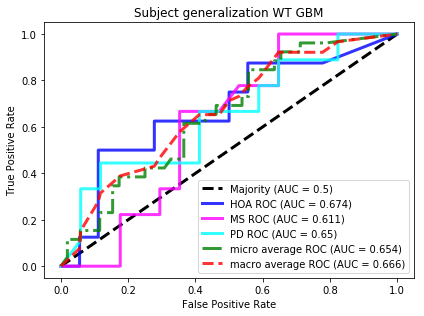

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.8}

Stride-based model performance (mean):  [0.408865829415553, 0.47865111190248405, 0.408865829415553, 0.5054426721237114, [0.3712680619822099, 0.47369628782100176, 0.5909889859042401], 0.4179026288147908, 0.408865829415553, 0.408865829415553, [0.4197455078594328, 0.3346271459163733, 0.499335232668566], 0.3784175788754187, 0.408865829415553, 0.37798418300079073, [0.38141556599189097, 0.33354765364942196, 0.4202895169849432], 0.6364035417531456, 0.6431665311575199]

Stride-based model performance (standard deviation):  [0.13564698907483205, 0.09114047264935923, 0.13564698907483205, 0.07220085539224486, [0.29791262304699795, 0.3147723076892591, 0.11795187593157591], 0.12469148317487584, 0.13564698907483205, 0.13564698907483205, [0.28448144327525327, 0.176334109787000

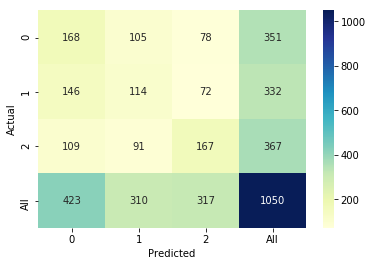

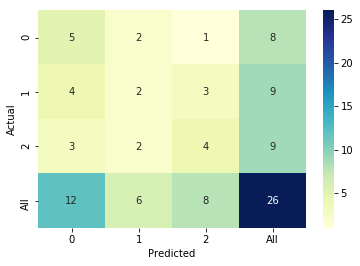

<Figure size 432x288 with 0 Axes>

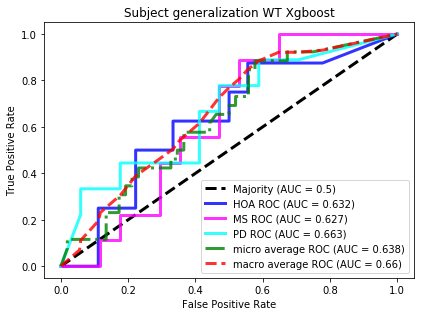

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 33}

Stride-based model performance (mean):  [0.40234715813253114, 0.42266598172645276, 0.40234715813253114, 0.4478149559405349, [0.3397970771933874, 0.43715896679772825, 0.49104190118824265], 0.4044223971306472, 0.40234715813253114, 0.40234715813253114, [0.34471823507742294, 0.3862251609472451, 0.4823237953672736], 0.3798753815361374, 0.40234715813253114, 0.3882861290950617, [0.3302384461594385, 0.3943152154824401, 0.41507248296653365], 0.5523190659033851, 0.5566715351921601]

Stride-based model performance (standard deviation):  [0.07537333139390408, 0.049230329383219154, 0.07537333139390408, 0.045636891094279104, [0.23269571504390082, 0.2596275299570852, 0.13304377753600485], 0.07074443763246915, 0.07537333139390408, 0.07537333139390408, [0.202543735830551, 0.08574159275997573, 0.3274966461883868], 0.06799079463182563, 0.07537333139390408, 0.06638079876631092, [0.19849072307045

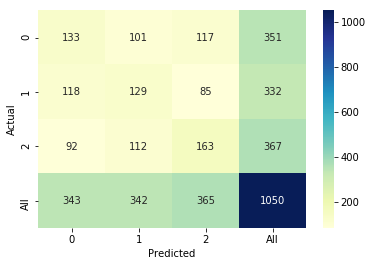

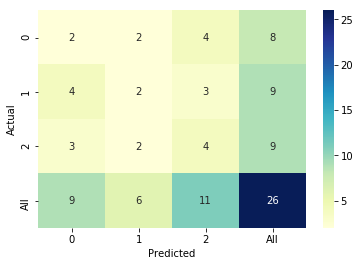

<Figure size 432x288 with 0 Axes>

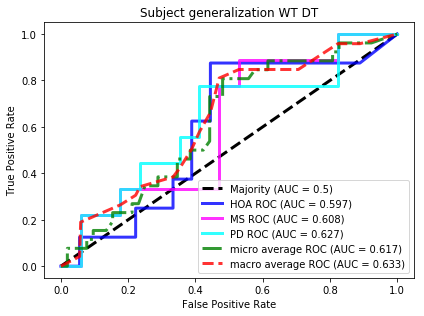

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.3978469149220773, 0.4390617700307227, 0.3978469149220773, 0.4644175120337365, [0.35158679205352894, 0.3738435984939767, 0.5917549195446624], 0.40496111112343786, 0.3978469149220773, 0.3978469149220773, [0.3882389422729385, 0.32810192443896635, 0.4985424666584087], 0.37502370641280447, 0.3978469149220773, 0.377960015787381, [0.36623668734925885, 0.29894950515640173, 0.4598849267327528], 0.6028692141008308, 0.607587676887628]

Stride-based model performance (standard deviation):  [0.1389605773933348, 0.1152864884254977, 0.1389605773933348, 0.11012541320697945, [0.26707236326512307, 0.15890154188355907, 0.19479918830780196], 0.1343460786797193, 0.1389605773933348, 0.1389605773933348, [0.2553293098830457, 0.21386276215632857, 0.3528563793127574], 0.1500444470038948, 0.1389605773933348, 0.15127964760790494, [0.2623934875043131, 0.16156158903160267, 0.2223121184130748]

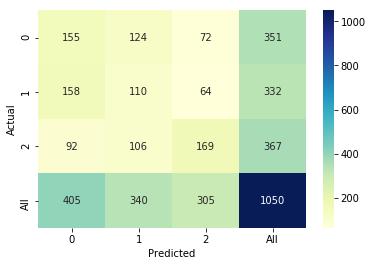

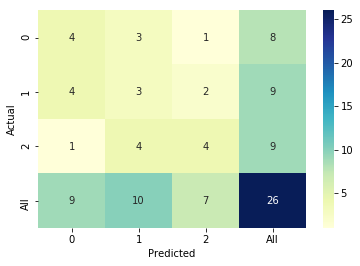

<Figure size 432x288 with 0 Axes>

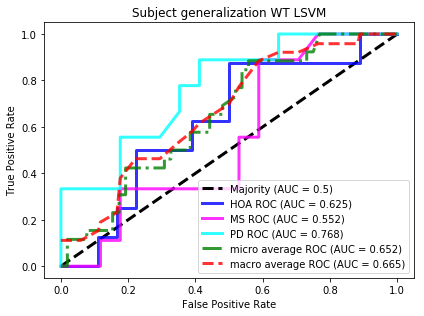

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 10, 100, 20, 100, 30, 5)}

Stride-based model performance (mean):  [0.4435546009216533, 0.47072526809735366, 0.4435546009216533, 0.49588556870244344, [0.35638265388988144, 0.4086347089443065, 0.6471584414578733], 0.4493358305926708, 0.4435546009216533, 0.4435546009216533, [0.5866549474441312, 0.1776248924902874, 0.5837276518435939], 0.3933986791531332, 0.4435546009216533, 0.3982176511330026, [0.42582683136644756, 0.2133660282737681, 0.541003177819184], 0.616700001709501, 0.6228057750882228]

Stride-based model performance (standard deviation):  [0.10898420174242156, 0.08337711761712249, 0.10898420174242156, 0.05873759023700012, [0.22525638314076485, 0.2593508566809998, 0.15489338476567927], 0.09637697845049184, 0.10898420174242156, 0.10898420174242156, [0.35845917137968214, 0.19644918789932153, 0.3490038820425308], 0.1307753021952234, 0.10898420174242156, 0.1320431497497799, [0.2436630

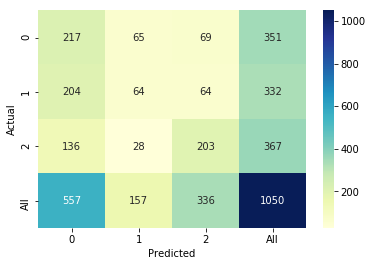

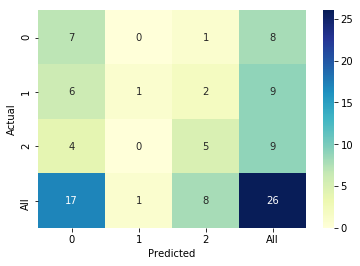

<Figure size 432x288 with 0 Axes>

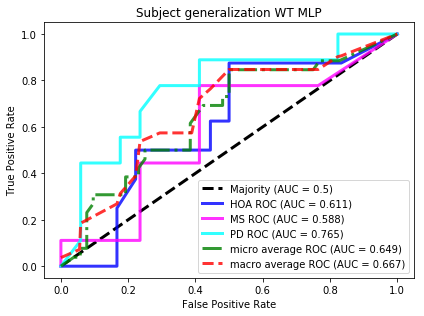

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.37582080008100693, 0.4063079668858235, 0.37582080008100693, 0.4271173429174445, [0.3393859661465295, 0.36566059563360226, 0.5138773388773389], 0.38210775270231084, 0.37582080008100693, 0.37582080008100693, [0.32430624775235606, 0.3204149623757169, 0.5016020479788595], 0.3567747618184972, 0.37582080008100693, 0.3599566217166384, [0.3284826204362268, 0.2928119373417252, 0.44902972767753974], 0.5719903881461263, 0.5767474233433357]

Stride-based model performance (standard deviation):  [0.15437128532324396, 0.1347797957235321, 0.15437128532324396, 0.1257227386985853, [0.29679263948228946, 0.18334160908179292, 0.14239623453717953], 0.15288665752242397, 0.15437128532324396, 0.15437128532324396, [0.24001796505007003, 0.22239227554467622, 0.34802104473504153], 0.16443942668848538, 0.15437128532324396,

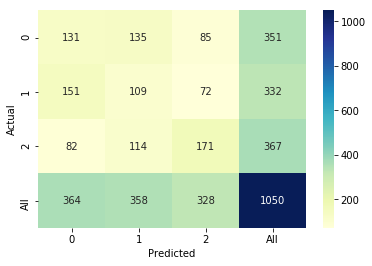

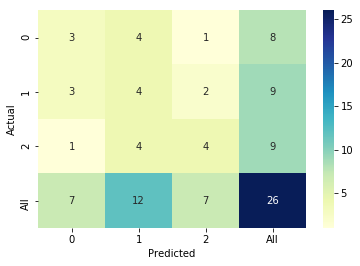

<Figure size 432x288 with 0 Axes>

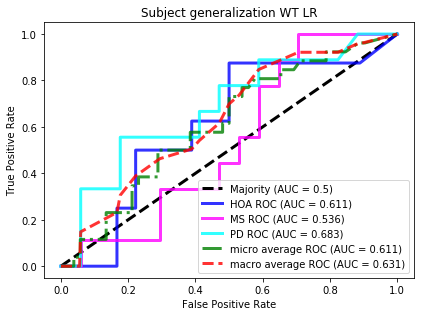

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 45}

Stride-based model performance (mean):  [0.44177658121496577, 0.5106205233587188, 0.44177658121496577, 0.5459969139087035, [0.4095115517696163, 0.44966557466557466, 0.6726844436409654], 0.44211968903665433, 0.44177658121496577, 0.44177658121496577, [0.4510795533230099, 0.22789109973187235, 0.6473884140550807], 0.3963559274178354, 0.44177658121496577, 0.4061886466864958, [0.40574469117433004, 0.242860780647457, 0.540462310431719], 0.6695029052395017, 0.6771617969263488]

Stride-based model performance (standard deviation):  [0.11759635128930432, 0.06040538167295207, 0.11759635128930432, 0.032450713468101584, [0.32514394948333336, 0.3373441894693477, 0.21485207258006697], 0.11232749459274853, 0.1175963

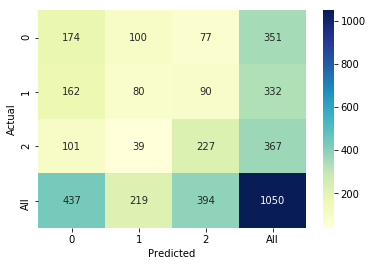

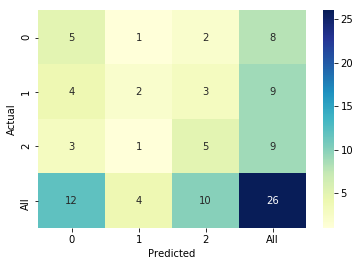

<Figure size 432x288 with 0 Axes>

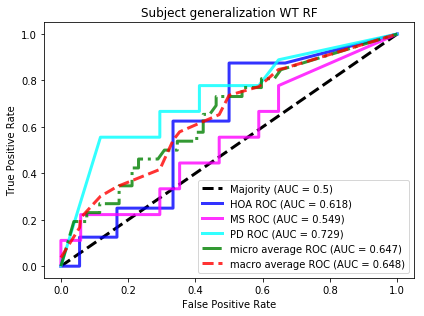

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 50}

Stride-based model performance (mean):  [0.4511603859851262, 0.46487598921983275, 0.4511603859851262, 0.4815702292496784, [0.4053411601077187, 0.33237320944638016, 0.6569135981053995], 0.44837310613603104, 0.4511603859851262, 0.4511603859851262, [0.632579000751541, 0.09549997742780618, 0.617040340228746], 0.37820669173017735, 0.4511603859851262, 0.389503232347164, [0.47069221310236486, 0.1217219290817102, 0.5422059330064569], 0.6393150072617593, 0.6441636481522118]

Stride-based model performance (standard deviation):  [0.10208347337717535, 0.13342661073356793, 0.10208347337717535, 0.1453518522760653, [0.27312862856111, 0.11189714360771186, 0.20231658041583855], 0.08873046733656519, 0.10208347337717535, 0.10208347337717535, [0.39026642304995585, 0.10004429896340934, 0.3390137769189937], 0.10940831882991577, 0.10208347337717535, 0.12166764850282254

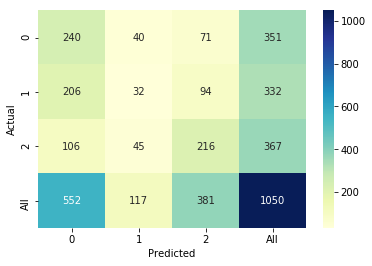

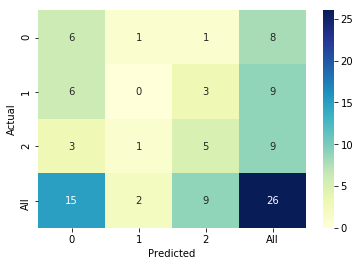

<Figure size 432x288 with 0 Axes>

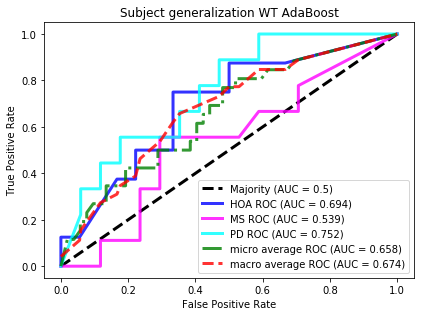

********************************
kernel_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4879350878238891, 0.4469492912152496, 0.4879350878238891, 0.4683777877115446, [0.4277393831588565, 0.19211674849972724, 0.7209917419871653], 0.49256696337148276, 0.4879350878238891, 0.4879350878238891, [0.5929002229443876, 0.19382250952523652, 0.6909781576448243], 0.41679225168503453, 0.4879350878238891, 0.4261520892926244, [0.4786618459494121, 0.15970399933482995, 0.6120109097708618], 0.7051583395634975, 0.7143491276070163]

Stride-based model performance (standard deviation):  [0.12020399722114787, 0.17114674152841128, 0.12020399722114787, 0.1882284611198244, [0.27994245207223434, 0.20303377125043298, 0.2495301376728465], 0.10158609236588112, 0.12020399722114787, 0.12020399722114787, [0.36283506907662, 0.335841934825919, 0.32699581116456167], 0.12255500816193782, 0.12020399722114787, 0.13352356109810437, [0.2938140096219309, 0.21967065849818304, 0.1196146137672

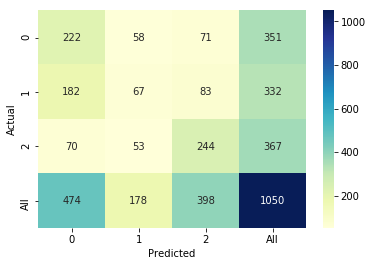

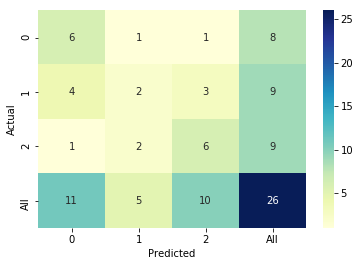

<Figure size 432x288 with 0 Axes>

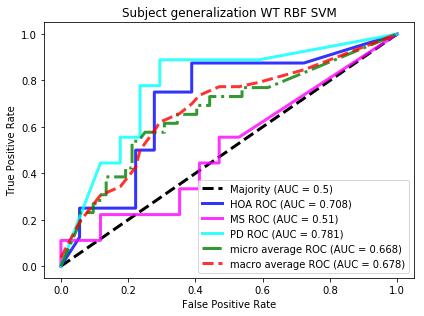

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 100}

Stride-based model performance (mean):  [0.4209809714657366, 0.4672606681750019, 0.4209809714657366, 0.49360445906137784, [0.38027533497672494, 0.4676718990653417, 0.5538347704829392], 0.42745809892383874, 0.4209809714657366, 0.4209809714657366, [0.4247079910209189, 0.3355184053418274, 0.5221479004087699], 0.3941506036725442, 0.4209809714657366, 0.39662356448821423, [0.38890774034172787, 0.3510664142707408, 0.44247765640516384], 0.6185063151649745, 0.6238455367100167]

Stride-based model performance (standard deviation):  [0.13726022514242592, 0.08975058314055395, 0.13726022514242592, 0.07330297300837538, [0.3076790446379756, 0.2794250787099

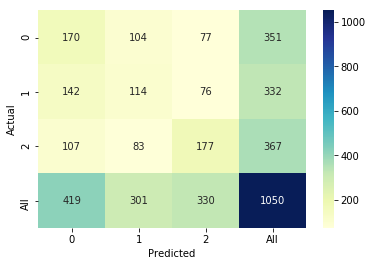

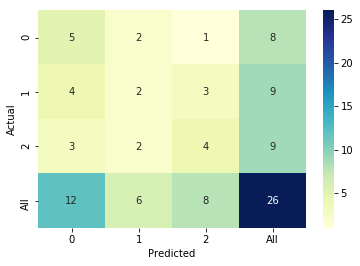

<Figure size 432x288 with 0 Axes>

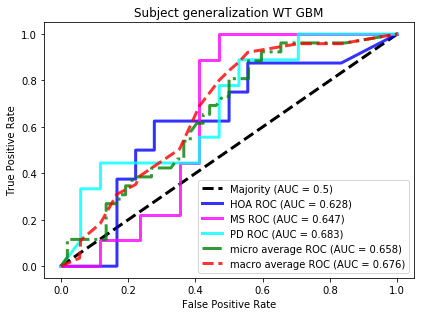

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.8}

Stride-based model performance (mean):  [0.4005474806622475, 0.4657004509932648, 0.4005474806622475, 0.49663893641656554, [0.3586701547962411, 0.4547851396617678, 0.5836460585217855], 0.40586494900473424, 0.4005474806622475, 0.4005474806622475, [0.4224720334246896, 0.28591103771107035, 0.5092117758784426], 0.3708585391434106, 0.4005474806622475, 0.3737950186503749, [0.37885715807698833, 0.3028249352240025, 0.43089352412924126], 0.6234706426404678, 0.6308852348169582]

Stride-based model performance (standard deviation):  [0.13909210691498505, 0.07541345824492302, 0.13909210691498505, 0.054752449878615723, [0.29091847522997843, 0.3266522541808294, 0.11516217412181172], 0.13137660198997886, 0.13909210691498505, 0.13909210691498505, [0.2881273003373622, 0.13831636153

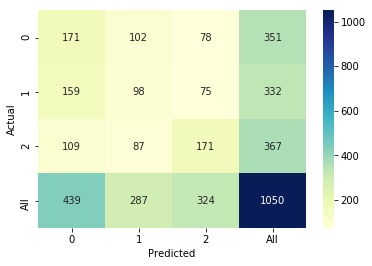

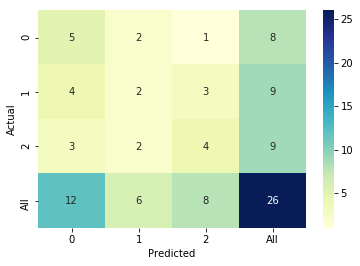

<Figure size 432x288 with 0 Axes>

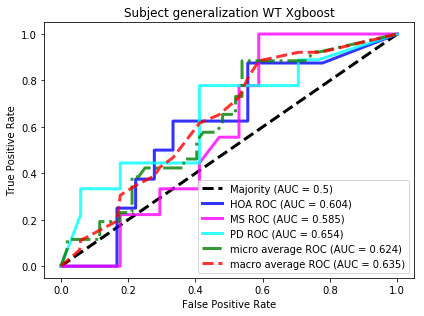

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 42}

Stride-based model performance (mean):  [0.4068017970111927, 0.42349107333287395, 0.4068017970111927, 0.44892304382418613, [0.3601853461457981, 0.44110401282166667, 0.4691838610311569], 0.41192040154591086, 0.4068017970111927, 0.4068017970111927, [0.37538292737530465, 0.41408817445058593, 0.44629010281184195], 0.38755457866120424, 0.4068017970111927, 0.3941565072873723, [0.35893633547702053, 0.40465662356966703, 0.39907077693692533], 0.5582784004709156, 0.5629232114632213]

Stride-based model performance (standard deviation):  [0.08451419360009998, 0.07191690352541404, 0.08451419360009998, 0.07303014198738311, [0.25492673299165847, 0.27178539661928375, 0.1507186327436872], 0.07999891787243248, 0.08451419360009998, 0.08451419360009998, [0.21340329873235978, 0.06789134026856065, 0.3378631103747997], 0.08666088339300891, 0.08451419360009998, 0.08637083971541626, [0.2227839048509

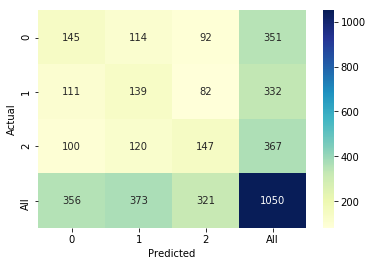

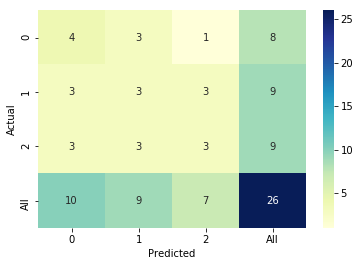

<Figure size 432x288 with 0 Axes>

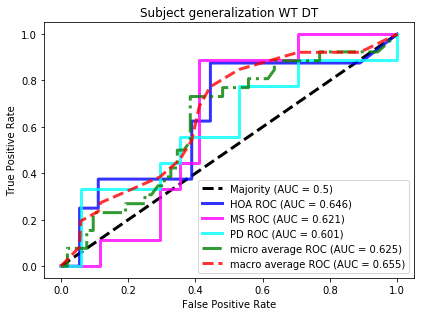

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.37455146220361757, 0.3924046099845243, 0.37455146220361757, 0.4125076090708708, [0.3307916426394284, 0.3185952006636284, 0.5278269866505161], 0.38018432055602275, 0.37455146220361757, 0.37455146220361757, [0.32434653312573747, 0.30729193991769715, 0.5089144886246335], 0.352342684279852, 0.37455146220361757, 0.3557970032868504, [0.3240792105258048, 0.27441639682478386, 0.4585324454889672], 0.5790480024566251, 0.5844111652890841]

Stride-based model performance (standard deviation):  [0.1421239702484273, 0.12983816136488432, 0.1421239702484273, 0.12272813550016269, [0.27350161896982683, 0.13379948380155243, 0.17524374260875974], 0.14123397623145156, 0.1421239702484273, 0.1421239702484273, [0.23379325494932213, 0.21616743467132712, 0.36112560881653527], 0.15334377437784952, 0.1421239702484273, 0.1530178608803505, [0.25193482104592285, 0.17039282309820938, 0.23779990

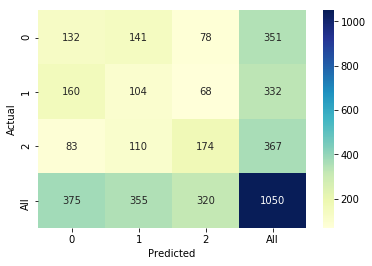

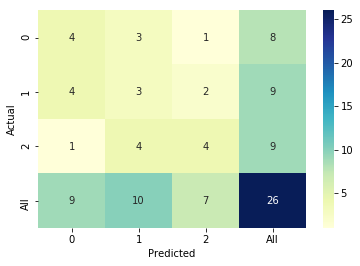

<Figure size 432x288 with 0 Axes>

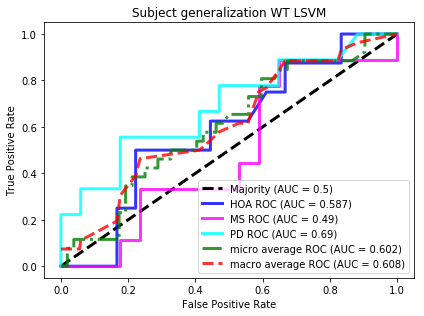

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 5, 5, 200, 100, 50, 30)}

Stride-based model performance (mean):  [0.4298298849975549, 0.44730838442640425, 0.4298298849975549, 0.47063043459272125, [0.39850377309393703, 0.434045755744215, 0.5093756244410604], 0.4344649837442791, 0.4298298849975549, 0.4298298849975549, [0.41182356521629654, 0.4065059415308066, 0.4850654444857343], 0.4120379838380944, 0.4298298849975549, 0.4167487290508265, [0.3934810353742875, 0.40060438101739726, 0.44202853512259854], 0.5938936365186805, 0.6005032809516357]

Stride-based model performance (standard deviation):  [0.11863290462273095, 0.0942664878692691, 0.11863290462273095, 0.07768410744308088, [0.29295937881621975, 0.18783388249517174, 0.1537051949339972], 0.11042031189034066, 0.11863290462273095, 0.11863290462273095, [0.2752547134168158, 0.11031202429910754, 0.3163893984299682], 0.12357533993192514, 0.11863290462273095, 0.12314505326754505, [0.269599959

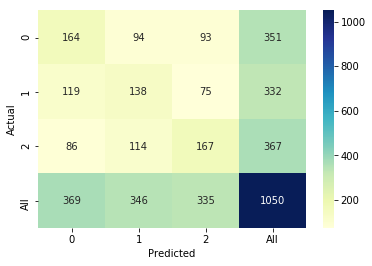

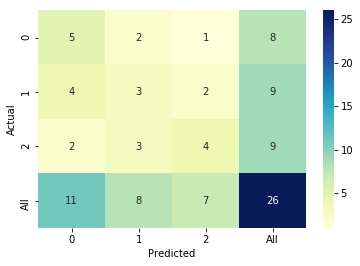

<Figure size 432x288 with 0 Axes>

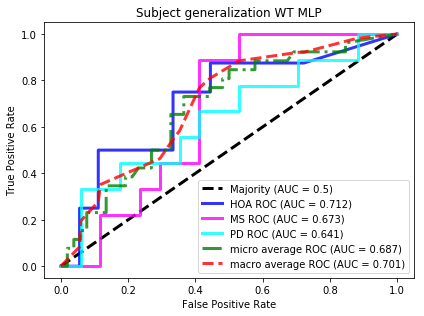

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.40822094423974686, 0.44933138376146686, 0.40822094423974686, 0.4740658290133286, [0.3449946424290736, 0.42964242576261513, 0.5733570830927119], 0.4129251752059259, 0.40822094423974686, 0.40822094423974686, [0.33678017234537166, 0.3656767604320739, 0.536318592840332], 0.39289508139389684, 0.40822094423974686, 0.39883875281261794, [0.3392317084624777, 0.3418983828072262, 0.49755515291198676], 0.6143899374106299, 0.6190837255008839]

Stride-based model performance (standard deviation):  [0.11405402800242123, 0.09211816062263305, 0.11405402800242123, 0.07791321786682333, [0.3077088268754938, 0.24898231357703168, 0.09337192186708045], 0.11132855726732843, 0.11405402800242123, 0.11405402800242123, [0.27148845016782436, 0.1480534585302169, 0.31245981972351317], 0.12233239574745515, 0.114054028002

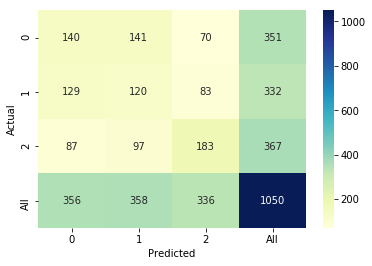

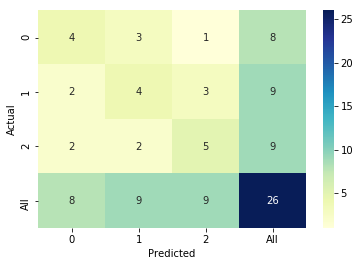

<Figure size 432x288 with 0 Axes>

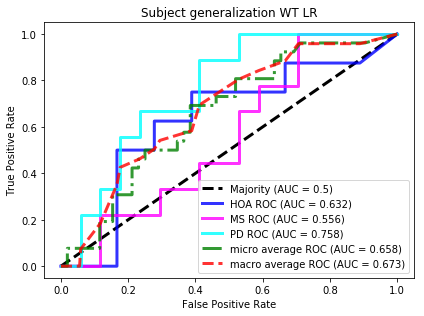

********************************
random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 45}

Stride-based model performance (mean):  [0.445942675930134, 0.5183565272234809, 0.445942675930134, 0.5542811106251857, [0.42430826118326115, 0.44937330631113037, 0.6813880141760511], 0.4444418092625784, 0.445942675930134, 0.445942675930134, [0.46681302010550035, 0.20165010948660328, 0.6648622981956315], 0.39749947015551007, 0.445942675930134, 0.4083757185384574, [0.41191870958494087, 0.22678547154935702, 0.5537942293322324], 0.7026392082567575, 0.710212378281022]

Stride-based model performance (standard deviation):  [0.12935496307531136, 0.07381031005933011, 0.12935496307531136, 0.04933234816289576, [0.34549287969908343, 0.34382701654484776, 0.2231787913465169], 0.12700491401172884, 0.12935496307531

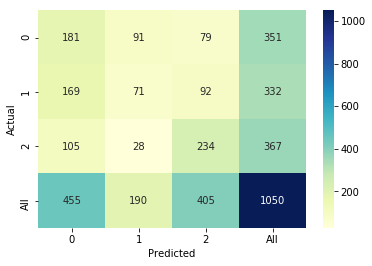

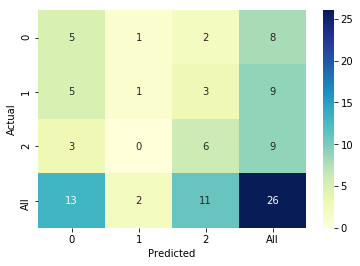

<Figure size 432x288 with 0 Axes>

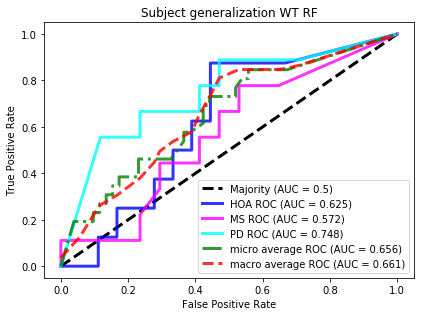

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 125}

Stride-based model performance (mean):  [0.47987099210791817, 0.5313800747533477, 0.47987099210791817, 0.556353194997742, [0.409042847828525, 0.4687328155538624, 0.7163645608776559], 0.4851750269825231, 0.47987099210791817, 0.47987099210791817, [0.5369165636239931, 0.29724099595605497, 0.6213675213675214], 0.4496231440283496, 0.47987099210791817, 0.4541206296202498, [0.4501442496956319, 0.3141452164193611, 0.5845799659700557], 0.7055728178303546, 0.7099739800693582]

Stride-based model performance (standard deviation):  [0.12330254421786892, 0.09219329935645287, 0.12330254421786892, 0.0876944320289728, [0.27934715377362496, 0.1789177584768527, 0.21312233870271166], 0.11559377428281326, 0.12330254421786892, 0.12330254421786892, [0.3025109028094678, 0.2171557249682615, 0.3025149012504095], 0.15001510779008084, 0.12330254421786893, 0.1570252955883120

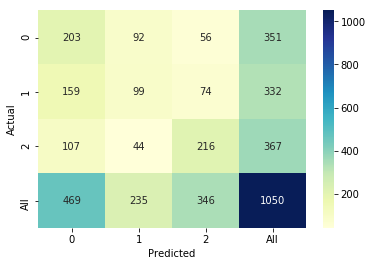

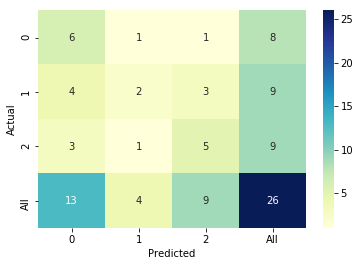

<Figure size 432x288 with 0 Axes>

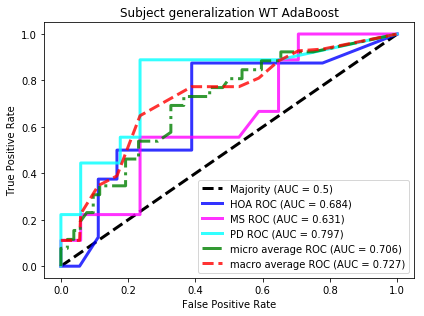

********************************
kernel_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4905346665520267, 0.44502905224865386, 0.4905346665520267, 0.4685594574028282, [0.4348786256550775, 0.1778205128205128, 0.7223880182703712], 0.4943410395342246, 0.4905346665520267, 0.4905346665520267, [0.5050727785066941, 0.2178363799820198, 0.7601139601139602], 0.43501189443481686, 0.4905346665520267, 0.4444018502097009, [0.4463320522235044, 0.18268292105574627, 0.6760207100251998], 0.721762664721432, 0.7310119753264724]

Stride-based model performance (standard deviation):  [0.13180087281657923, 0.17639978745884596, 0.13180087281657923, 0.19116920296155956, [0.30359020407713727, 0.1963399904437931, 0.2462000329858654], 0.12055303642190714, 0.13180087281657923, 0.13180087281657923, [0.32244955751822885, 0.3382286113738571, 0.24682005680044625], 0.1465756333617057, 0.13180087281657923, 0.15246105995747758, [0.29304641992396446, 0.23779585226370947, 0.075283658401

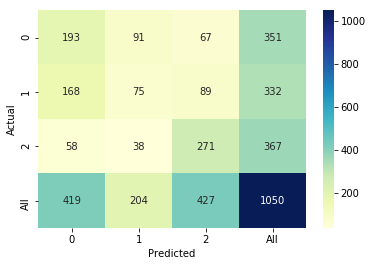

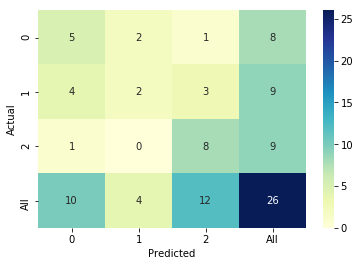

<Figure size 432x288 with 0 Axes>

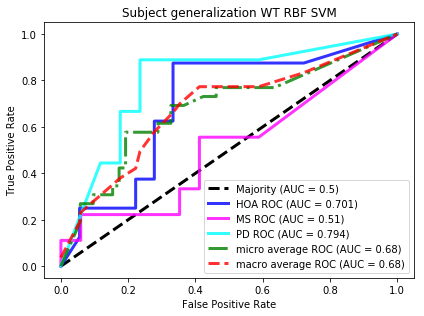

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 150}

Stride-based model performance (mean):  [0.45087160764856177, 0.5061503449103547, 0.45087160764856177, 0.5364063625712433, [0.4054478115899211, 0.49095430668542644, 0.6220489164557165], 0.4545042274427568, 0.45087160764856177, 0.45087160764856177, [0.43286470127477333, 0.36151217858436124, 0.5691358024691358], 0.4255109415337392, 0.45087160764856177, 0.43198429498761826, [0.4014556018920337, 0.3728159809056193, 0.5022612418035647], 0.6724127325894481, 0.6790766445300458]

Stride-based model performance (standard deviation):  [0.13551649374750088, 0.09308595812252213, 0.13551649374750088, 0.07030661519663998, [0.3310536181195305, 0.302589036

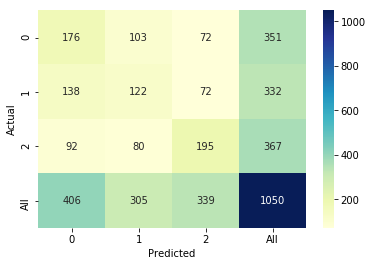

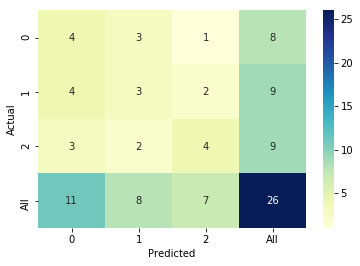

<Figure size 432x288 with 0 Axes>

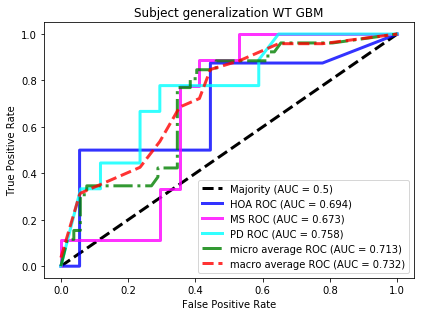

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}

Stride-based model performance (mean):  [0.44429800405653663, 0.49036715879147286, 0.44429800405653663, 0.5190211557089295, [0.392037228395298, 0.4802972105937019, 0.5987670373854184], 0.4474965655261222, 0.44429800405653663, 0.44429800405653663, [0.418491534626991, 0.3641691021223156, 0.5598290598290598], 0.4199774725303832, 0.44429800405653663, 0.4265881659804321, [0.38611401022570346, 0.3769007878633547, 0.4969176195020914], 0.6859328979094292, 0.6917248792282974]

Stride-based model performance (standard deviation):  [0.13810971822691384, 0.10059424619543145, 0.13810971822691384, 0.08188360239036425, [0.3195129385724896, 0.31194815217624167, 0.1022897432916244], 0.13253442669381243, 0.13810971822691384, 0.13810971822691384, [0.29731354844402497, 0.1789033183

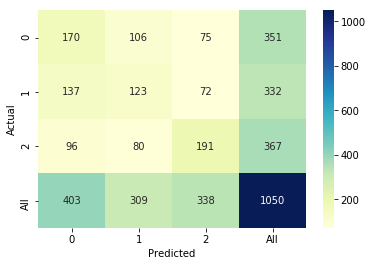

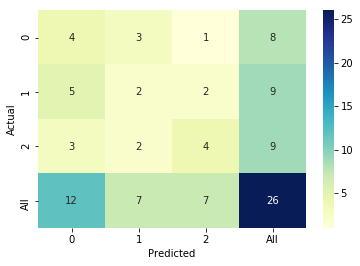

<Figure size 432x288 with 0 Axes>

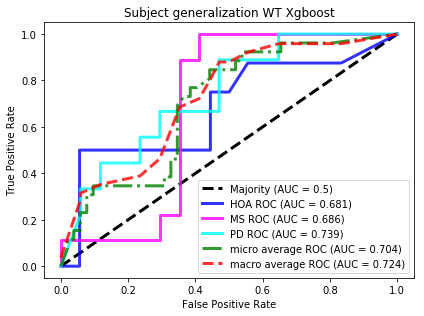

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 45}

Stride-based model performance (mean):  [0.4664348837587844, 0.4692091798020849, 0.4664348837587844, 0.49394870863056256, [0.3928907730280728, 0.4051565658769289, 0.6095802005012532], 0.4692027152195296, 0.4664348837587844, 0.4664348837587844, [0.45831344890114656, 0.4369201148176427, 0.5123745819397993], 0.44064847060330636, 0.4664348837587844, 0.44725352582760386, [0.41592564061898174, 0.4076878132937624, 0.4983319578971752], 0.58669372427053, 0.5906706481593466]

Stride-based model performance (standard deviation):  [0.055563968763223746, 0.05692299897836774, 0.055563968763223746, 0.0625447311735532, [0.24304862746018213, 0.20925643169649566, 0.14775168195546487], 0.040572351635202085, 0.055563968763223746, 0.055563968763223746, [0.26332535937529894, 0.22377648453492488, 0.25780784625527686], 0.057289784492593566, 0.05556396876322373, 0.06271990719719377, [0.24478723782387

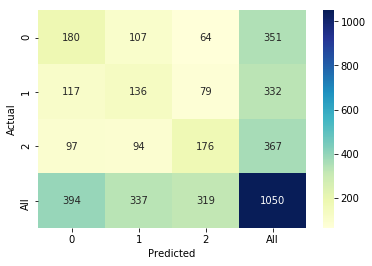

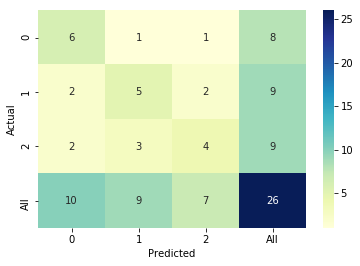

<Figure size 432x288 with 0 Axes>

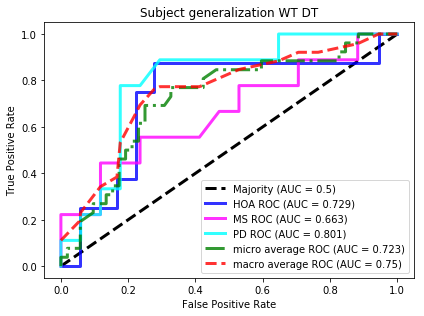

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}

Stride-based model performance (mean):  [0.4139825864111114, 0.45043387548463976, 0.4139825864111114, 0.475122964053316, [0.32420994067660736, 0.4423350785653721, 0.5847566072119398], 0.41739103318259607, 0.4139825864111114, 0.4139825864111114, [0.3597686780924981, 0.3662472721097348, 0.5261571493455551], 0.3953741262827574, 0.4139825864111114, 0.4016715308621904, [0.338568889091884, 0.35160396845406333, 0.49594952130232506], 0.62965785463122, 0.6353168577807884]

Stride-based model performance (standard deviation):  [0.1098251680274698, 0.08804567910403291, 0.1098251680274698, 0.07326612161423812, [0.2791698009881023, 0.23777868777237138, 0.10895056017630288], 0.10742700988357984, 0.1098251680274698, 0.1098251680274698, [0.28536810495519305, 0.158640464823504, 0.3067951886257763], 0.12072585633094357, 0.1098251680274698, 0.11804703590915339, [0.2788918276640879, 0.08934002685652746, 0.14264280634920726],

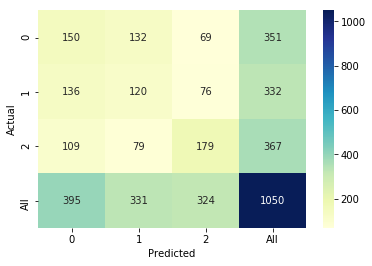

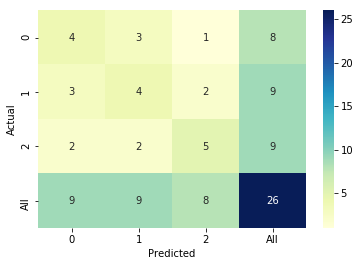

<Figure size 432x288 with 0 Axes>

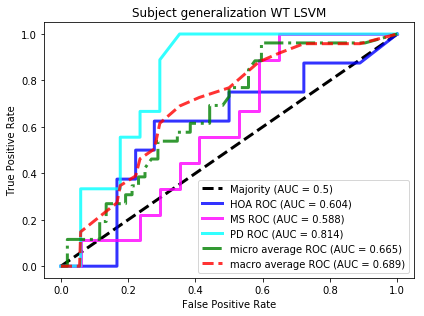

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 50, 20, 150, 5, 10)}

Stride-based model performance (mean):  [0.49472938630378127, 0.5093303997919442, 0.49472938630378127, 0.5401356787490561, [0.3644885256577929, 0.5077677014947517, 0.6557349722232881], 0.4945139225557532, 0.49472938630378127, 0.49472938630378127, [0.38988183892719575, 0.438537917096313, 0.6551220116437508], 0.46862916117067577, 0.49472938630378127, 0.4791051969979711, [0.3728277666713852, 0.4401585278533476, 0.5929011889872946], 0.6335675901017128, 0.6386209023373931]

Stride-based model performance (standard deviation):  [0.13611555443961, 0.09271183205261595, 0.13611555443961, 0.06428239637588327, [0.3206709892124471, 0.28247675374685977, 0.12542480712030674], 0.1280561055757218, 0.13611555443961, 0.13611555443961, [0.34676196449156443, 0.16787402231734583, 0.3153657097018935], 0.13964778147259285, 0.13611555443961, 0.1364763456882792, [0.3249116301786096, 0

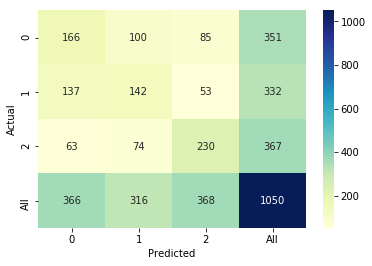

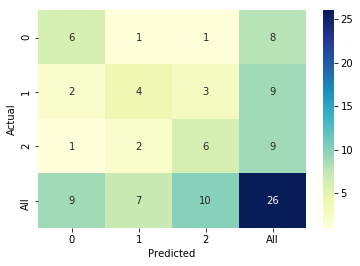

<Figure size 432x288 with 0 Axes>

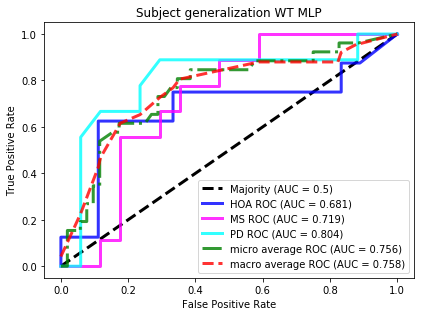

********************************
********************************


In [14]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X_WT[datastream], Y_WT, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics_WT[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics_WT.to_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [15]:
metrics_WT

(logistic_regression, feet)  \
stride_accuracy_mean                                                       0.380714   
stride_precision_macro_mean                                                0.436617   
stride_precision_micro_mean                                                0.380714   
stride_precision_weighted_mean                                             0.464861   
stride_precision_class_wise_mean  [0.3362198685941135, 0.43661303630363035, 0.53...   
stride_recall_macro_mean                                                   0.389422   
stride_recall_micro_mean                                                   0.380714   
stride_recall_weighted_mean                                                0.380714   
stride_recall_class_wise_mean     [0.3334593507585421, 0.3412987686003318, 0.493...   
stride_F1_macro_mean                                                       0.362063   
stride_F1_micro_mean                                                       0.380714   
stride_F1_weighted_mean                                                     0.36468   
stride_F1_class_wise_mean         [0.3285608609911772, 0.31837025881626074, 0.43...   
stride_AUC_macro_mean                                                      0.586517   
stride_AUC_weighted_mean                                                    0.59154   
stride_accuracy_std                                                        0.132863   
stride_precision_macro_std                                                 0.106803   
stride_precision_micro_std                                                 0.132863   
stride_precision_weighted_std                                               0.10521   
stride_precision_class_wise_std   [0.2592077426210226, 0.279560475748365, 0.1832...   
stride_recall_macro_std                                                    0.131108   
stride_recall_micro_std                                                    0.132863   
stride_recall_weighted_std                                                 0.132863   
stride_recall_class_wise_std      [0.1964859082263077, 0.21286695975917772, 0.35...   
stride_F1_macro_std                                                         0.14221   
stride_F1_micro_std                                                        0.132863   
stride_F1_weighted_std                                                     0.141272   
stride_F1_class_wise_std          [0.2246487649854405, 0.15510383084081417, 0.21...   
stride_AUC_macro_std                                                       0.121786   
stride_AUC_weighted_std                                                    0.117695   
person_accuracy_mean                                                       0.383333   
person_precision_macro_mean                                                     0.4   
person_precision_micro_mean                                                0.383333   
person_precision_weighted_mean                                             0.566667   
person_precision_class_wise_mean                                    [0.3, 0.4, 0.5]   
person_recall_macro_mean                                                   0.357778   
person_recall_micro_mean                                                   0.383333   
person_recall_weighted_mean                                                0.383333   
person_recall_class_wise_mean        [0.4, 0.2733333333333333, 0.39999999999999997]   
person_F1_macro_mean                                                       0.347937   
person_F1_micro_mean                                                       0.383333   
person_F1_weighted_mean                                                    0.427063   
person_F1_class_wise_mean                                           [0.3, 0.4, 0.5]   
person_AUC_macro_mean                                                      0.608333   
person_AUC_weighted_mean                                                   0.633333   
person_accuracy_std                                   

### Reading the final metrics from the saved file

In [16]:
ablation_subject_generalizeWT = pd.read_csv(results_path+ framework + '\\subject_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_subject_generalizeWT.index = ablation_subject_generalizeWT['Unnamed: 0']
ablation_subject_generalizeWT.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_subject_generalizeWT.columns = [literal_eval(ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_subject_generalizeWT.loc['person_accuracy_mean'].index))]

In [17]:
ablation_subject_generalizeWT

(logistic_regression, feet)  \
Unnamed: 0                                                                            
stride_accuracy_mean                                             0.3807142762988591   
stride_precision_macro_mean                                      0.4366167539075473   
stride_precision_micro_mean                                      0.3807142762988591   
stride_precision_weighted_mean                                    0.464860689914065   
stride_precision_class_wise_mean  [0.3362198685941135, 0.43661303630363035, 0.53...   
stride_recall_macro_mean                                         0.3894224492169037   
stride_recall_micro_mean                                         0.3807142762988591   
stride_recall_weighted_mean                                      0.3807142762988591   
stride_recall_class_wise_mean     [0.3334593507585421, 0.3412987686003318, 0.493...   
stride_F1_macro_mean                                            0.36206256997498504   
stride_F1_micro_mean                                             0.3807142762988591   
stride_F1_weighted_mean                                         0.36468046117882646   
stride_F1_class_wise_mean         [0.3285608609911772, 0.31837025881626074, 0.43...   
stride_AUC_macro_mean                                            0.5865168406930874   
stride_AUC_weighted_mean                                         0.5915403730232298   
stride_accuracy_std                                             0.13286292203045727   
stride_precision_macro_std                                      0.10680315619204211   
stride_precision_micro_std                                      0.13286292203045727   
stride_precision_weighted_std                                   0.10520951523659966   
stride_precision_class_wise_std   [0.2592077426210226, 0.279560475748365, 0.1832...   
stride_recall_macro_std                                         0.13110842044946602   
stride_recall_micro_std                                         0.13286292203045727   
stride_recall_weighted_std                                      0.13286292203045727   
stride_recall_class_wise_std      [0.1964859082263077, 0.21286695975917772, 0.35...   
stride_F1_macro_std                                              0.1422104898750283   
stride_F1_micro_std                                             0.13286292203045727   
stride_F1_weighted_std                                          0.14127171481998962   
stride_F1_class_wise_std          [0.2246487649854405, 0.15510383084081417, 0.21...   
stride_AUC_macro_std                                             0.1217863836850729   
stride_AUC_weighted_std                                         0.11769508798248825   
person_accuracy_mean                                             0.3833333333333333   
person_precision_macro_mean                                                     0.4   
person_precision_micro_mean                                      0.3833333333333333   
person_precision_weighted_mean                                   0.5666666666666667   
person_precision_class_wise_mean                                    [0.3, 0.4, 0.5]   
person_recall_macro_mean                                        0.35777777777777775   
person_recall_micro_mean                                         0.3833333333333333   
person_recall_weighted_mean                                      0.3833333333333333   
person_recall_class_wise_mean        [0.4, 0.2733333333333333, 0.39999999999999997]   
person_F1_macro_mean                                            0.34793650793650793   
person_F1_micro_mean                                             0.3833333333333333   
person_F1_weighted_mean                                         0.42706349206349203   
person_F1_class_wise_mean                                           [0.3, 0.4, 0.5]   
person_AUC_macro_mean                                            0.6083333333333333   
person_AUC_weighted_mean                              

### Heatmap for person mean accuracy for all algorithms and data streams for Subject generalize in trial WT

In [18]:
person_accuracy_subject_generlaizeWT = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_subject_generalizeWT.columns)):
    x = ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_subject_generalizeWT.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_subject_generlaizeWT.loc[x, y] = ablation_subject_generalizeWT.loc['person_accuracy_mean'][(y, x)]

person_accuracy_subject_generlaizeWT = person_accuracy_subject_generlaizeWT.astype(float)

In [19]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_subject_generlaizeWT.loc['All features'] = [np.nan]*9

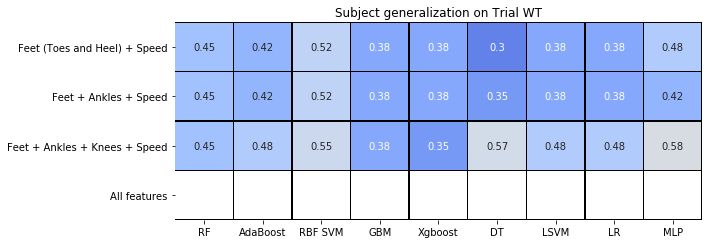

In [20]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_subject_generlaizeWT, vmin=0.3, vmax=1.0, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Subject generalization on Trial WT')
plt.tight_layout()
plt.savefig(results_path + framework + '\\subject_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()